In [1]:
import sys
sys.path.append('/home/andrea/Documentos/OF-PathPred/evaluation_opticalflow/lib')
import numpy as np
#from process_file import process_file_modif
#from process_file import process_file_modif_varios
#from process_file import datos_subprocesados_varios
from interseccion_process_file import process_file_modif_varios_inter
from interseccion_process_file import process_file_modif_inter
from interaction_optical_flow import OpticalFlowSimulator

import batches_data
import model

import tensorflow as tf 
tf.reset_default_graph()

import entrenamientoevaluacion
from entrenamientoevaluacion import evaluate

In [2]:
# parametros para preprocesar los datos
# en marco mundo
class parameters:
    def __init__(self):
        #el numero de personas maximasdel conjunto de test
        self.person_max = 14
        #el indice del conjunto de test
        self.ind_test = 2
        self.obs_len = 8
        self.pred_len = 12
        self.add_social = True
        self.kp_num = 18
        self.add_kp = False
        #self.directory_flujo='../evaluation_opticalflow/flujos'
arguments = parameters()

In [3]:
# Cargamos los argumentos
data_dirs = ['../data1/eth-univ', '../data1/eth-hotel',
             '../data1/ucy-zara01', '../data1/ucy-zara02',
             '../data1/ucy-univ']

#list_max_person = [42,28,22,26,68]
list_max_person_inter = [5,8,14,14,40]
data_train_and_val = process_file_modif_varios_inter(data_dirs, list_max_person_inter, arguments, ',')
print("\n\n")
dir_test = data_dirs[arguments.ind_test]
data_test = process_file_modif_inter(dir_test, arguments,',')

fo = OpticalFlowSimulator()
flujo_test, vis_neigh_test = fo.compute_opticalflow_batch(data_test['obs_person'], data_test['key_idx'], data_test['obs_traj'],arguments.obs_len)
data_test.update({
    "obs_flujo": flujo_test,
})



../data1/eth-univ/mundo/mun_pos.csv
('The numbers of examples is: ', 339)
../data1/eth-hotel/mundo/mun_pos.csv
('The numbers of examples is: ', 913)
../data1/ucy-zara02/mundo/mun_pos.csv
('The numbers of examples is: ', 5910)
../data1/ucy-univ/mundo/mun_pos.csv
('The numbers of examples is: ', 10039)



('[INF] Sequence length: ', 20)
../data1/ucy-zara01/mundo/mun_pos.csv
('El numero total de ejemplos es: ', 2356)


# We divide the data

In [4]:
#se fija la semilaa
import random
random.seed(0)

# Muestreamos aleatoriamente para separar datos de entrenamiento, validacion y prueba


# porcentaje para el conjunto de train
prob      = 0.92
# La cantidad total de listas de tam 8 del conjunto train and test
ndata     = len(data_train_and_val[list(data_train_and_val.keys())[2]])
idx       = random.sample(range(ndata), ndata)
long1     = int(ndata*prob)
long2     = int(ndata-long1)

idx_train = idx[0:long1]
idx_val   = idx[long1:]


# conjunto de entrenamiento
data1 = {
     "obs_traj": data_train_and_val["obs_traj"][idx_train],
     "obs_traj_rel": data_train_and_val["obs_traj_rel"][idx_train],
    
     "pred_traj": data_train_and_val["pred_traj"][idx_train],
     "pred_traj_rel": data_train_and_val["pred_traj_rel"][idx_train],
    
     #"key_idx": data_entrena_vali["key_idx"][[idx_train]],
     "obs_flujo" : data_train_and_val["obs_flujo"][idx_train],
     #"pred_kp": data_pets["pred_kp"][idx_train],
     #"obs_person": data_pets["obs_person"][idx_train],
}


# conjunto de validacion
data3 ={
     "obs_traj": data_train_and_val["obs_traj"][idx_val],
     "obs_traj_rel": data_train_and_val["obs_traj_rel"][idx_val],
     "pred_traj": data_train_and_val["pred_traj"][idx_val],
     "pred_traj_rel": data_train_and_val["pred_traj_rel"][idx_val],
     #"key_idx": data_entrena_vali["key_idx"][[idx_val]],
     "obs_flujo" : data_train_and_val["obs_flujo"][idx_val],
}


#if arguments.add_kp:
#  print(data3['obs_person_rel'])

print("data_train: "+ str(len(data1[list(data1.keys())[0]])))
print("data_test: "+ str(len(data_test[list(data_test.keys())[0]])))
print("data_val: "+ str(len(data3[list(data3.keys())[0]])))


data_train: 15824
data_test: 2356
data_val: 1377


# We keep the division of the data

In [5]:
import pickle

#conjunto de entrenamiento
pickle_out = open("data1_FO_UCY-ZARA01_12.pickle","wb")
pickle.dump(data1, pickle_out, protocol=2)
pickle_out.close()

#conjunto de prueba
pickle_out = open("data2_FO_UCY-ZARA01_12.pickle","wb")
pickle.dump(data_test, pickle_out, protocol=2)
pickle_out.close()

#conjunto de validacion
pickle_out = open("data3_FO_UCY-ZARA01_12.pickle","wb")
pickle.dump(data3, pickle_out, protocol=2)
pickle_out.close()

# Model parameters

In [6]:
class parameters1:
    def __init__(self, add_kp = None, add_social=None, train_num_examples=None):
        # -----------------
        # Similar a como se procesaron los datos
        self.obs_len = 8
        self.pred_len = 12
        if add_kp is None:
            print('Parameter add kpp missing')
            return
        if train_num_examples is None:
            print('El parametro train_examples fue olvidado')
            return
        if add_social is None:
            print('Parameter add social missing')
            return
        
        self.add_kp = add_kp
        self.train_num_examples = train_num_examples
        self.add_social = add_social
        
        self.kp_num = 18
        self.kp_size = 18
        
        self.num_epochs = 100
        self.batch_size = 20 # batch size
        self.validate = 300
        self.P = 2 # dimensión
        self.enc_hidden_size = 128 # el nombre lo dice
        self.dec_hidden_size = 128
        self.emb_size = 64
        self.keep_prob = 0.7 # dropout
        
        self.min_ped = 1
        self.seq_len = self.obs_len + self.pred_len
        self.reverse_xy = False
        
        self.activation_func = tf.nn.tanh
        self.activation_func1 = tf.nn.relu
        self.is_train = True
        self.is_test = False
        self.multi_decoder = False
        self.modelname = 'gphuctl'
        
        self.init_lr = 0.002 # 0.01
        self.learning_rate_decay = 0.85
        self.num_epoch_per_decay = 2.0
        self.optimizer = 'adam'
        self.emb_lr = 1.0
        #self.clip_gradient_norm = 10.0
        #Para cuando entreno y quiero guardar el mejor modelo
        self.load_best = True

# Model training

In [7]:
import os 
from tqdm import tqdm
import tensorflow as tf
import math

tf.reset_default_graph()

arguments = parameters1(add_kp = False, add_social = True, train_num_examples=len(data1['obs_traj']))
model = model.Model(arguments)

train_data = batches_data.Dataset(data1,arguments)
val_data = batches_data.Dataset(data3,arguments)

saver = tf.train.Saver(max_to_keep = 2)
bestsaver = tf.train.Saver(max_to_keep = 2)


trainer = entrenamientoevaluacion.Trainer(model,arguments)
tester = entrenamientoevaluacion.Tester(model, arguments)

#inicializamos las variables globales
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

increment_global_step_op = tf.assign(model.global_step, model.global_step+1)

val_perf = []
loss = -1
metric = 'ade'

best = {metric:999999, 'fde':0, 'step':-1}
is_start = True

num_steps = int(math.ceil(train_data.num_examples/float(arguments.batch_size)))
loss_list = []
print(num_steps)

for i in range(arguments.num_epochs):
    print('Epoca {0}.' .format(i+1), 'lr:', sess.run(trainer.get_lr()))
    
    #For de batches
    for idx, batch in tqdm(train_data.get_batches(arguments.batch_size,num_steps = num_steps),total=num_steps):
        
        sess.run(increment_global_step_op)
        global_step = sess.run(model.global_step)

        #Evaluamos el entrenamiento
        if((global_step%arguments.validate==0) or (arguments.load_best and is_start)):
            tqdm.write("\tsaving model %s..." % global_step)
            checkpoint_path_model = os.path.join('FO_UCY-ZARA01_NON_12', 'model.ckpt')
            saver.save(sess,checkpoint_path_model , global_step = global_step)
            tqdm.write("\tdone")
            
            print('Evaluating')
            results = evaluate(val_data, tester,sess,arguments)
            print(results)
           
            tqdm.write(("\t last loss:%.9f, eval on validation:%s,"
                    " (best %s:%s at step %s) ") % (loss,["%s: %s" % (k, results[k]) for k in sorted(results.keys())], metric,best[metric], best["step"]))
            if results["ade"]< best[metric]:
                best[metric] = results["ade"]
                best["fde"]  = results["fde"]
                best["step"] = global_step
                
                tqdm.write("\t saving best model...")
                checkpoint_path_model_best = os.path.join('FO_UCY-ZARA01_NON-BEST_12', 'model_best.ckpt')
                bestsaver.save(sess,checkpoint_path_model_best,global_step = global_step)
                tqdm.write("\t done.")
                finalperf = results
                val_perf.append((loss, results))
            is_start = False
        loss, train_op = trainer.step(sess, batch)
        loss_list.append(loss)
    
if((global_step % arguments.validate)!=0):
  checkpoint_path_model = os.path.join('FO_UCY-ZARA01_NON_12', 'model.ckpt')
  saver.save(sess,checkpoint_path_model , global_step = global_step)

print("best eval on val %s: %s at %s step y fde es %s " % (metric, best[metric], best["step"],best["fde"]))


W0523 11:32:25.376718 140131420743424 deprecation.py:323] From /home/andrea/Documentos/OF-PathPred/evaluation_opticalflow/lib/model.py:60: __init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0523 11:32:25.418247 140131420743424 deprecation.py:323] From /home/andrea/Documentos/OF-PathPred/evaluation_opticalflow/lib/model.py:102: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0523 11:32:25.504301 140131420743424 deprecation.py:506] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions f

792
('Epoca 1.', 'lr:', 0.002)
	saving model 1...



  0%|          | 0/69 [00:00<?, ?it/s]

	done
Evaluating



100%|##########| 69/69 [00:01<00:00, 53.06it/s]

{'ade': 1.5518346, 'fde': 2.8107023}
	 last loss:-1.000000000, eval on validation:['ade: 1.5518346', 'fde: 2.8107023'], (best ade:999999 at step -1) 
	 saving best model...
	 done.


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 300...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 76.60it/s]

{'ade': 0.5384065, 'fde': 1.1728702}
	 last loss:0.000557835, eval on validation:['ade: 0.5384065', 'fde: 1.1728702'], (best ade:1.5518346 at step 1) 
	 saving best model...
	 done.


 76%|███████▌  | 598/792 [00:28<00:07, 26.57it/s]W0523 11:32:57.254751 140131420743424 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.

  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 600...
	done
Evaluating



 76%|███████▌  | 601/792 [00:29<00:26,  7.19it/s]A

{'ade': 0.54108125, 'fde': 1.1886005}
	 last loss:0.000507890, eval on validation:['ade: 0.54108125', 'fde: 1.1886005'], (best ade:0.5384065 at step 300) 


  0%|          | 2/792 [00:00<00:44, 17.67it/s]

('Epoca 2.', 'lr:', 0.002)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 900...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 86.90it/s]

{'ade': 0.52453023, 'fde': 1.1513307}
	 last loss:0.000562502, eval on validation:['ade: 0.52453023', 'fde: 1.1513307'], (best ade:0.5384065 at step 300) 
	 saving best model...
	 done.


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 1200...
	done
Evaluating



 52%|█████▏    | 411/792 [00:19<00:40,  9.38it/s]A

{'ade': 0.5272688, 'fde': 1.151444}
	 last loss:0.000537005, eval on validation:['ade: 0.5272688', 'fde: 1.151444'], (best ade:0.52453023 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 1500...
	done
Evaluating



 90%|████████▉ | 711/792 [00:31<00:09,  8.82it/s]A

{'ade': 0.5279603, 'fde': 1.150927}
	 last loss:0.000529065, eval on validation:['ade: 0.5279603', 'fde: 1.150927'], (best ade:0.52453023 at step 900) 


  0%|          | 1/792 [00:00<01:35,  8.24it/s]

('Epoca 3.', 'lr:', 0.0017000001)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 1800...
	done
Evaluating



 28%|██▊       | 220/792 [00:09<01:00,  9.48it/s]A

{'ade': 0.59222317, 'fde': 1.3380568}
	 last loss:0.000356835, eval on validation:['ade: 0.59222317', 'fde: 1.3380568'], (best ade:0.52453023 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 2100...
	done
Evaluating



 65%|██████▌   | 517/792 [00:22<00:40,  6.73it/s]A

{'ade': 0.5965461, 'fde': 1.3679894}
	 last loss:0.000605979, eval on validation:['ade: 0.5965461', 'fde: 1.3679894'], (best ade:0.52453023 at step 900) 


  0%|          | 1/792 [00:00<01:29,  8.84it/s]

('Epoca 4.', 'lr:', 0.0017000001)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 2400...
	done
Evaluating



  3%|▎         | 25/792 [00:02<01:52,  6.79it/s][A

{'ade': 0.562415, 'fde': 1.2475789}
	 last loss:0.000544285, eval on validation:['ade: 0.562415', 'fde: 1.2475789'], (best ade:0.52453023 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 2700...
	done
Evaluating



 41%|████      | 325/792 [00:14<01:01,  7.54it/s]A

{'ade': 0.533169, 'fde': 1.1629361}
	 last loss:0.000610940, eval on validation:['ade: 0.533169', 'fde: 1.1629361'], (best ade:0.52453023 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 3000...
	done
Evaluating



 79%|███████▉  | 625/792 [00:27<00:24,  6.88it/s]A

{'ade': 0.5964286, 'fde': 1.3228697}
	 last loss:0.000481504, eval on validation:['ade: 0.5964286', 'fde: 1.3228697'], (best ade:0.52453023 at step 900) 


  0%|          | 2/792 [00:00<00:51, 15.36it/s]

('Epoca 5.', 'lr:', 0.0014450002)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 3300...
	done
Evaluating



 17%|█▋        | 136/792 [00:06<01:08,  9.52it/s]A

{'ade': 0.56765205, 'fde': 1.2730355}
	 last loss:0.000407706, eval on validation:['ade: 0.56765205', 'fde: 1.2730355'], (best ade:0.52453023 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 3600...
	done
Evaluating



 55%|█████▌    | 436/792 [00:19<00:41,  8.53it/s]A

{'ade': 0.52677727, 'fde': 1.1509824}
	 last loss:0.000440021, eval on validation:['ade: 0.52677727', 'fde: 1.1509824'], (best ade:0.52453023 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 3900...
	done
Evaluating



 93%|█████████▎| 733/792 [00:32<00:08,  7.12it/s]A

{'ade': 0.5394108, 'fde': 1.2037257}
	 last loss:0.000473261, eval on validation:['ade: 0.5394108', 'fde: 1.2037257'], (best ade:0.52453023 at step 900) 


  0%|          | 1/792 [00:00<01:33,  8.49it/s]

('Epoca 6.', 'lr:', 0.0014450002)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 4200...
	done
Evaluating



 31%|███       | 244/792 [00:10<00:57,  9.53it/s]A

{'ade': 0.6214568, 'fde': 1.3975755}
	 last loss:0.000664475, eval on validation:['ade: 0.6214568', 'fde: 1.3975755'], (best ade:0.52453023 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 4500...
	done
Evaluating



 68%|██████▊   | 541/792 [00:23<00:36,  6.92it/s]A

{'ade': 0.53569067, 'fde': 1.1851037}
	 last loss:0.000647740, eval on validation:['ade: 0.53569067', 'fde: 1.1851037'], (best ade:0.52453023 at step 900) 


  0%|          | 2/792 [00:00<00:52, 15.13it/s]

('Epoca 7.', 'lr:', 0.0012282502)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 4800...
	done
Evaluating



  6%|▋         | 50/792 [00:02<01:39,  7.48it/s][A

{'ade': 0.60872984, 'fde': 1.3706248}
	 last loss:0.000490684, eval on validation:['ade: 0.60872984', 'fde: 1.3706248'], (best ade:0.52453023 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 5100...
	done
Evaluating



 44%|████▍     | 350/792 [00:16<01:03,  6.98it/s]A

{'ade': 0.5617185, 'fde': 1.2508782}
	 last loss:0.000563634, eval on validation:['ade: 0.5617185', 'fde: 1.2508782'], (best ade:0.52453023 at step 900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 5400...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 82.06it/s]

{'ade': 0.5059166, 'fde': 1.0944911}
	 last loss:0.000362165, eval on validation:['ade: 0.5059166', 'fde: 1.0944911'], (best ade:0.52453023 at step 900) 
	 saving best model...
	 done.


  0%|          | 1/792 [00:00<01:36,  8.23it/s]

('Epoca 8.', 'lr:', 0.0012282502)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 5700...
	done
Evaluating



 20%|██        | 159/792 [00:07<01:06,  9.50it/s]A

{'ade': 0.5234224, 'fde': 1.1431475}
	 last loss:0.000458826, eval on validation:['ade: 0.5234224', 'fde: 1.1431475'], (best ade:0.5059166 at step 5400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 6000...
	done
Evaluating



 58%|█████▊    | 458/792 [00:20<00:38,  8.61it/s]A

{'ade': 0.5103602, 'fde': 1.1022254}
	 last loss:0.000402002, eval on validation:['ade: 0.5103602', 'fde: 1.1022254'], (best ade:0.5059166 at step 5400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 6300...
	done
Evaluating



 96%|█████████▌| 758/792 [00:33<00:04,  7.49it/s]A

{'ade': 0.5191596, 'fde': 1.1384333}
	 last loss:0.000306637, eval on validation:['ade: 0.5191596', 'fde: 1.1384333'], (best ade:0.5059166 at step 5400) 


  0%|          | 1/792 [00:00<01:33,  8.48it/s]

('Epoca 9.', 'lr:', 0.0010440127)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 6600...
	done
Evaluating



 33%|███▎      | 265/792 [00:11<01:12,  7.31it/s]A

{'ade': 0.51581794, 'fde': 1.1321297}
	 last loss:0.000262609, eval on validation:['ade: 0.51581794', 'fde: 1.1321297'], (best ade:0.5059166 at step 5400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 6900...
	done
Evaluating



 71%|███████▏  | 565/792 [00:24<00:33,  6.84it/s]A

{'ade': 0.5613178, 'fde': 1.2450535}
	 last loss:0.000795114, eval on validation:['ade: 0.5613178', 'fde: 1.2450535'], (best ade:0.5059166 at step 5400) 


  0%|          | 2/792 [00:00<00:45, 17.23it/s]

('Epoca 10.', 'lr:', 0.0010440127)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 7200...
	done
Evaluating



 10%|▉         | 76/792 [00:04<01:15,  9.44it/s][A

{'ade': 0.53385365, 'fde': 1.1841767}
	 last loss:0.000683213, eval on validation:['ade: 0.53385365', 'fde: 1.1841767'], (best ade:0.5059166 at step 5400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 7500...
	done
Evaluating



 47%|████▋     | 376/792 [00:18<00:48,  8.61it/s]A

{'ade': 0.5763691, 'fde': 1.2877362}
	 last loss:0.000592171, eval on validation:['ade: 0.5763691', 'fde: 1.2877362'], (best ade:0.5059166 at step 5400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 7800...
	done
Evaluating



 85%|████████▍ | 673/792 [00:31<00:19,  6.13it/s]A

{'ade': 0.57448304, 'fde': 1.2841172}
	 last loss:0.000515892, eval on validation:['ade: 0.57448304', 'fde: 1.2841172'], (best ade:0.5059166 at step 5400) 


  0%|          | 1/792 [00:00<01:57,  6.72it/s]

('Epoca 11.', 'lr:', 0.0008874108)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 8100...
	done
Evaluating



 23%|██▎       | 183/792 [00:09<01:04,  9.38it/s]A

{'ade': 0.5236847, 'fde': 1.1487737}
	 last loss:0.000660734, eval on validation:['ade: 0.5236847', 'fde: 1.1487737'], (best ade:0.5059166 at step 5400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 8400...
	done
Evaluating



 61%|██████    | 483/792 [00:22<00:35,  8.78it/s]A

{'ade': 0.559621, 'fde': 1.2536738}
	 last loss:0.000474914, eval on validation:['ade: 0.559621', 'fde: 1.2536738'], (best ade:0.5059166 at step 5400) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 8700...
	done
Evaluating



 98%|█████████▊| 780/792 [00:34<00:01,  6.84it/s]A

{'ade': 0.50132954, 'fde': 1.0827391}
	 last loss:0.000719291, eval on validation:['ade: 0.50132954', 'fde: 1.0827391'], (best ade:0.5059166 at step 5400) 
	 saving best model...
	 done.


  0%|          | 2/792 [00:00<00:48, 16.38it/s]

('Epoca 12.', 'lr:', 0.0008874108)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 9000...
	done
Evaluating



 37%|███▋      | 290/792 [00:12<01:09,  7.25it/s]A

{'ade': 0.5420627, 'fde': 1.1885363}
	 last loss:0.000613074, eval on validation:['ade: 0.5420627', 'fde: 1.1885363'], (best ade:0.50132954 at step 8700) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 9300...
	done
Evaluating



 74%|███████▍  | 590/792 [00:26<00:31,  6.31it/s]A

{'ade': 0.5167587, 'fde': 1.1362779}
	 last loss:0.000721892, eval on validation:['ade: 0.5167587', 'fde: 1.1362779'], (best ade:0.50132954 at step 8700) 


  0%|          | 1/792 [00:00<01:37,  8.11it/s]

('Epoca 13.', 'lr:', 0.0007542992)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 9600...
	done
Evaluating



 13%|█▎        | 100/792 [00:05<01:17,  8.90it/s]A

{'ade': 0.52635914, 'fde': 1.1483768}
	 last loss:0.000776470, eval on validation:['ade: 0.52635914', 'fde: 1.1483768'], (best ade:0.50132954 at step 8700) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 9900...
	done
Evaluating



 51%|█████     | 400/792 [00:17<00:41,  9.43it/s]A

{'ade': 0.52008647, 'fde': 1.1367916}
	 last loss:0.000505743, eval on validation:['ade: 0.52008647', 'fde: 1.1367916'], (best ade:0.50132954 at step 8700) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 10200...
	done
Evaluating



 88%|████████▊ | 700/792 [00:30<00:09,  9.54it/s]A

{'ade': 0.50568026, 'fde': 1.0987685}
	 last loss:0.000320640, eval on validation:['ade: 0.50568026', 'fde: 1.0987685'], (best ade:0.50132954 at step 8700) 


  0%|          | 1/792 [00:00<01:48,  7.29it/s]

('Epoca 14.', 'lr:', 0.0007542992)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 10500...
	done
Evaluating



 26%|██▌       | 205/792 [00:09<01:22,  7.09it/s]A

{'ade': 0.55658096, 'fde': 1.2252005}
	 last loss:0.000530451, eval on validation:['ade: 0.55658096', 'fde: 1.2252005'], (best ade:0.50132954 at step 8700) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 10800...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 85.46it/s]

{'ade': 0.4941389, 'fde': 1.0630212}
	 last loss:0.000436992, eval on validation:['ade: 0.4941389', 'fde: 1.0630212'], (best ade:0.50132954 at step 8700) 
	 saving best model...
	 done.


  0%|          | 2/792 [00:00<00:44, 17.81it/s]

('Epoca 15.', 'lr:', 0.0006411543)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 11100...
	done
Evaluating



  2%|▏         | 16/792 [00:01<01:52,  6.90it/s][A

{'ade': 0.51076406, 'fde': 1.1116829}
	 last loss:0.000466783, eval on validation:['ade: 0.51076406', 'fde: 1.1116829'], (best ade:0.4941389 at step 10800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 11400...
	done
Evaluating



 40%|███▉      | 316/792 [00:14<00:50,  9.50it/s]A

{'ade': 0.5020722, 'fde': 1.0879722}
	 last loss:0.000388347, eval on validation:['ade: 0.5020722', 'fde: 1.0879722'], (best ade:0.4941389 at step 10800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 11700...
	done
Evaluating



 77%|███████▋  | 613/792 [00:28<00:28,  6.36it/s]A

{'ade': 0.5257309, 'fde': 1.1511682}
	 last loss:0.000880911, eval on validation:['ade: 0.5257309', 'fde: 1.1511682'], (best ade:0.4941389 at step 10800) 


  0%|          | 1/792 [00:00<01:30,  8.73it/s]

('Epoca 16.', 'lr:', 0.0006411543)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 12000...
	done
Evaluating



 16%|█▌        | 124/792 [00:05<01:12,  9.22it/s]A

{'ade': 0.49519122, 'fde': 1.0751324}
	 last loss:0.000258827, eval on validation:['ade: 0.49519122', 'fde: 1.0751324'], (best ade:0.4941389 at step 10800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 12300...
	done
Evaluating



 53%|█████▎    | 421/792 [00:18<00:51,  7.20it/s]A

{'ade': 0.5126224, 'fde': 1.1261936}
	 last loss:0.000377308, eval on validation:['ade: 0.5126224', 'fde: 1.1261936'], (best ade:0.4941389 at step 10800) 


 91%|█████████ | 718/792 [00:30<00:03, 21.63it/s]

	saving model 12600...



 10%|#         | 7/69 [00:00<00:00, 62.73it/s]

	done
Evaluating



100%|##########| 69/69 [00:01<00:00, 65.09it/s]

{'ade': 0.4902176, 'fde': 1.0584099}
	 last loss:0.000262050, eval on validation:['ade: 0.4902176', 'fde: 1.0584099'], (best ade:0.4941389 at step 10800) 
	 saving best model...


 91%|█████████ | 721/792 [00:31<00:14,  5.02it/s]

	 done.


  0%|          | 3/792 [00:00<00:34, 22.93it/s]

('Epoca 17.', 'lr:', 0.0005449812)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 12900...
	done
Evaluating



 29%|██▉       | 230/792 [00:10<01:13,  7.68it/s]A

{'ade': 0.513309, 'fde': 1.1207402}
	 last loss:0.000302258, eval on validation:['ade: 0.513309', 'fde: 1.1207402'], (best ade:0.4902176 at step 12600) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 13200...
	done
Evaluating



 67%|██████▋   | 530/792 [00:23<00:35,  7.37it/s]A

{'ade': 0.5108472, 'fde': 1.1260943}
	 last loss:0.000508063, eval on validation:['ade: 0.5108472', 'fde: 1.1260943'], (best ade:0.4902176 at step 12600) 


  0%|          | 1/792 [00:00<01:41,  7.77it/s]

('Epoca 18.', 'lr:', 0.0005449812)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 13500...
	done
Evaluating



  5%|▌         | 40/792 [00:02<01:24,  8.86it/s][A

{'ade': 0.4965091, 'fde': 1.0772681}
	 last loss:0.000573344, eval on validation:['ade: 0.4965091', 'fde: 1.0772681'], (best ade:0.4902176 at step 12600) 


 42%|████▏     | 334/792 [00:14<00:22, 20.64it/s]

	saving model 13800...



 43%|████▎     | 337/792 [00:15<01:20,  5.68it/s]A

	done
Evaluating
{'ade': 0.5097282, 'fde': 1.1090069}
	 last loss:0.000239877, eval on validation:['ade: 0.5097282', 'fde: 1.1090069'], (best ade:0.4902176 at step 12600) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 14100...
	done
Evaluating



 81%|████████  | 639/792 [00:29<00:15,  9.67it/s]A

{'ade': 0.50914645, 'fde': 1.1132568}
	 last loss:0.000345823, eval on validation:['ade: 0.50914645', 'fde: 1.1132568'], (best ade:0.4902176 at step 12600) 


  0%|          | 1/792 [00:00<01:36,  8.22it/s]

('Epoca 19.', 'lr:', 0.00046323403)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 14400...
	done
Evaluating



 19%|█▊        | 148/792 [00:06<01:08,  9.40it/s]A

{'ade': 0.49134165, 'fde': 1.0610744}
	 last loss:0.000279371, eval on validation:['ade: 0.49134165', 'fde: 1.0610744'], (best ade:0.4902176 at step 12600) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 14700...
	done
Evaluating



 57%|█████▋    | 448/792 [00:19<00:38,  8.99it/s]A

{'ade': 0.5202508, 'fde': 1.1460568}
	 last loss:0.000309201, eval on validation:['ade: 0.5202508', 'fde: 1.1460568'], (best ade:0.4902176 at step 12600) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 15000...
	done
Evaluating



 94%|█████████▍| 748/792 [00:33<00:04,  9.03it/s]A

{'ade': 0.4933933, 'fde': 1.0662054}
	 last loss:0.000415689, eval on validation:['ade: 0.4933933', 'fde: 1.0662054'], (best ade:0.4902176 at step 12600) 


  0%|          | 3/792 [00:00<00:31, 25.00it/s]

('Epoca 20.', 'lr:', 0.00046323403)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 15300...
	done
Evaluating



 32%|███▏      | 255/792 [00:10<00:56,  9.53it/s]A

{'ade': 0.50663424, 'fde': 1.1089457}
	 last loss:0.000491463, eval on validation:['ade: 0.50663424', 'fde: 1.1089457'], (best ade:0.4902176 at step 12600) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 15600...
	done
Evaluating



 70%|███████   | 555/792 [00:23<00:24,  9.49it/s]A

{'ade': 0.50786066, 'fde': 1.1051445}
	 last loss:0.000536881, eval on validation:['ade: 0.50786066', 'fde: 1.1051445'], (best ade:0.4902176 at step 12600) 


  0%|          | 1/792 [00:00<02:00,  6.54it/s]

('Epoca 21.', 'lr:', 0.00039374892)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 15900...
	done
Evaluating



  8%|▊         | 63/792 [00:04<01:30,  8.02it/s][A

{'ade': 0.50813746, 'fde': 1.1073705}
	 last loss:0.000615823, eval on validation:['ade: 0.50813746', 'fde: 1.1073705'], (best ade:0.4902176 at step 12600) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 16200...
	done
Evaluating



 46%|████▌     | 363/792 [00:17<00:47,  8.99it/s]A

{'ade': 0.49794972, 'fde': 1.0827707}
	 last loss:0.000547404, eval on validation:['ade: 0.49794972', 'fde: 1.0827707'], (best ade:0.4902176 at step 12600) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 16500...
	done
Evaluating



 84%|████████▎ | 663/792 [00:29<00:13,  9.52it/s]A

{'ade': 0.5012396, 'fde': 1.095893}
	 last loss:0.000321304, eval on validation:['ade: 0.5012396', 'fde: 1.095893'], (best ade:0.4902176 at step 12600) 


  0%|          | 1/792 [00:00<01:21,  9.65it/s]

('Epoca 22.', 'lr:', 0.00039374892)


 21%|██        | 166/792 [00:09<00:46, 13.35it/s]

	saving model 16800...



  6%|5         | 4/69 [00:00<00:01, 36.14it/s]

	done
Evaluating



 22%|██▏       | 171/792 [00:11<02:07,  4.88it/s]A

{'ade': 0.5014587, 'fde': 1.0956463}
	 last loss:0.000521099, eval on validation:['ade: 0.5014587', 'fde: 1.0956463'], (best ade:0.4902176 at step 12600) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 17100...
	done
Evaluating



 59%|█████▉    | 469/792 [00:24<00:47,  6.76it/s]A

{'ade': 0.4968718, 'fde': 1.076309}
	 last loss:0.000367442, eval on validation:['ade: 0.4968718', 'fde: 1.076309'], (best ade:0.4902176 at step 12600) 


 97%|█████████▋| 766/792 [00:37<00:01, 20.86it/s]

	saving model 17400...



 10%|#         | 7/69 [00:00<00:00, 62.54it/s]

	done
Evaluating



 97%|█████████▋| 769/792 [00:38<00:04,  5.48it/s]A

{'ade': 0.50517, 'fde': 1.1089344}
	 last loss:0.000530478, eval on validation:['ade: 0.50517', 'fde: 1.1089344'], (best ade:0.4902176 at step 12600) 


  0%|          | 1/792 [00:00<01:43,  7.64it/s]

('Epoca 23.', 'lr:', 0.0003346866)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 17700...
	done
Evaluating



 35%|███▌      | 279/792 [00:12<00:57,  8.90it/s]A

{'ade': 0.51168454, 'fde': 1.1212872}
	 last loss:0.000408147, eval on validation:['ade: 0.51168454', 'fde: 1.1212872'], (best ade:0.4902176 at step 12600) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 18000...
	done
Evaluating



 73%|███████▎  | 576/792 [00:25<00:32,  6.73it/s]A

{'ade': 0.48937997, 'fde': 1.0641012}
	 last loss:0.000655155, eval on validation:['ade: 0.48937997', 'fde: 1.0641012'], (best ade:0.4902176 at step 12600) 
	 saving best model...
	 done.


  0%|          | 1/792 [00:00<01:19,  9.92it/s]

('Epoca 24.', 'lr:', 0.0003346866)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 18300...
	done
Evaluating



 11%|█         | 85/792 [00:04<01:41,  7.00it/s][A

{'ade': 0.5105382, 'fde': 1.118993}
	 last loss:0.000495533, eval on validation:['ade: 0.5105382', 'fde: 1.118993'], (best ade:0.48937997 at step 18000) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 18600...
	done
Evaluating



 49%|████▉     | 387/792 [00:18<00:43,  9.40it/s]A

{'ade': 0.49247417, 'fde': 1.0759029}
	 last loss:0.000218487, eval on validation:['ade: 0.49247417', 'fde: 1.0759029'], (best ade:0.48937997 at step 18000) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 18900...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 83.47it/s]

{'ade': 0.48677692, 'fde': 1.0506254}
	 last loss:0.000348382, eval on validation:['ade: 0.48677692', 'fde: 1.0506254'], (best ade:0.48937997 at step 18000) 
	 saving best model...
	 done.


  0%|          | 1/792 [00:00<01:25,  9.28it/s]

('Epoca 25.', 'lr:', 0.00028448363)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 19200...
	done
Evaluating



 25%|██▍       | 196/792 [00:08<01:02,  9.58it/s]A

{'ade': 0.49252823, 'fde': 1.066277}
	 last loss:0.000221753, eval on validation:['ade: 0.49252823', 'fde: 1.066277'], (best ade:0.48677692 at step 18900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 19500...
	done
Evaluating



 62%|██████▏   | 493/792 [00:22<00:44,  6.74it/s]A

{'ade': 0.4873716, 'fde': 1.055152}
	 last loss:0.000368773, eval on validation:['ade: 0.4873716', 'fde: 1.055152'], (best ade:0.48677692 at step 18900) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 19800...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 88.81it/s]

{'ade': 0.48296022, 'fde': 1.0444499}
	 last loss:0.000885124, eval on validation:['ade: 0.48296022', 'fde: 1.0444499'], (best ade:0.48677692 at step 18900) 
	 saving best model...
	 done.


  0%|          | 2/792 [00:00<00:43, 18.01it/s]

('Epoca 26.', 'lr:', 0.00028448363)


 38%|███▊      | 299/792 [00:13<00:22, 22.33it/s]


	saving model 20100...
	done
Evaluating


 38%|███▊      | 302/792 [00:14<01:13,  6.70it/s]A

{'ade': 0.48802838, 'fde': 1.0564661}
	 last loss:0.000558109, eval on validation:['ade: 0.48802838', 'fde: 1.0564661'], (best ade:0.48296022 at step 19800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 20400...
	done
Evaluating



 76%|███████▌  | 602/792 [00:27<00:25,  7.44it/s]A

{'ade': 0.49757254, 'fde': 1.079689}
	 last loss:0.000525122, eval on validation:['ade: 0.49757254', 'fde: 1.079689'], (best ade:0.48296022 at step 19800) 


  0%|          | 2/792 [00:00<00:55, 14.13it/s]

('Epoca 27.', 'lr:', 0.0002418111)


 13%|█▎        | 105/792 [00:04<00:29, 23.03it/s]

	saving model 20700...



 12%|#1        | 8/69 [00:00<00:00, 74.08it/s]

	done
Evaluating



 14%|█▍        | 111/792 [00:06<01:25,  7.94it/s]A

{'ade': 0.509272, 'fde': 1.1117114}
	 last loss:0.000428032, eval on validation:['ade: 0.509272', 'fde: 1.1117114'], (best ade:0.48296022 at step 19800) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 21000...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 87.43it/s]

{'ade': 0.4803727, 'fde': 1.0412782}
	 last loss:0.000405665, eval on validation:['ade: 0.4803727', 'fde: 1.0412782'], (best ade:0.48296022 at step 19800) 
	 saving best model...
	 done.


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 21300...
	done
Evaluating



 90%|████████▉ | 711/792 [00:32<00:09,  8.71it/s]A

{'ade': 0.4949538, 'fde': 1.0786148}
	 last loss:0.000399692, eval on validation:['ade: 0.4949538', 'fde: 1.0786148'], (best ade:0.4803727 at step 21000) 


  0%|          | 2/792 [00:00<00:52, 15.08it/s]

('Epoca 28.', 'lr:', 0.0002418111)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 21600...
	done
Evaluating



 28%|██▊       | 218/792 [00:10<01:23,  6.90it/s]A

{'ade': 0.4878476, 'fde': 1.0579717}
	 last loss:0.000926331, eval on validation:['ade: 0.4878476', 'fde: 1.0579717'], (best ade:0.4803727 at step 21000) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 21900...
	done
Evaluating



 65%|██████▌   | 518/792 [00:23<00:38,  7.10it/s]A

{'ade': 0.4873405, 'fde': 1.0561785}
	 last loss:0.000484645, eval on validation:['ade: 0.4873405', 'fde: 1.0561785'], (best ade:0.4803727 at step 21000) 


  0%|          | 1/792 [00:00<01:45,  7.46it/s]

('Epoca 29.', 'lr:', 0.00020553943)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 22200...
	done
Evaluating



  4%|▎         | 28/792 [00:02<01:23,  9.10it/s][A

{'ade': 0.49273795, 'fde': 1.0699395}
	 last loss:0.000651887, eval on validation:['ade: 0.49273795', 'fde: 1.0699395'], (best ade:0.4803727 at step 21000) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 22500...
	done
Evaluating



 41%|████      | 325/792 [00:16<01:14,  6.28it/s]A

{'ade': 0.48496848, 'fde': 1.051112}
	 last loss:0.000346011, eval on validation:['ade: 0.48496848', 'fde: 1.051112'], (best ade:0.4803727 at step 21000) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 22800...
	done
Evaluating



 79%|███████▉  | 628/792 [00:29<00:17,  9.33it/s]A

{'ade': 0.49282846, 'fde': 1.0725864}
	 last loss:0.000312530, eval on validation:['ade: 0.49282846', 'fde: 1.0725864'], (best ade:0.4803727 at step 21000) 


  0%|          | 1/792 [00:00<01:34,  8.41it/s]

('Epoca 30.', 'lr:', 0.00020553943)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 23100...
	done
Evaluating



 17%|█▋        | 133/792 [00:06<01:36,  6.84it/s]A

{'ade': 0.48799294, 'fde': 1.0654018}
	 last loss:0.000794681, eval on validation:['ade: 0.48799294', 'fde: 1.0654018'], (best ade:0.4803727 at step 21000) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 23400...
	done
Evaluating



 55%|█████▍    | 434/792 [00:20<00:51,  6.92it/s]A

{'ade': 0.4822445, 'fde': 1.0441837}
	 last loss:0.000487173, eval on validation:['ade: 0.4822445', 'fde: 1.0441837'], (best ade:0.4803727 at step 21000) 


 92%|█████████▏| 730/792 [00:33<00:03, 17.18it/s]

	saving model 23700...



 10%|#         | 7/69 [00:00<00:01, 61.04it/s]

	done
Evaluating



 93%|█████████▎| 734/792 [00:34<00:11,  4.87it/s]A

{'ade': 0.4865654, 'fde': 1.0538807}
	 last loss:0.000448060, eval on validation:['ade: 0.4865654', 'fde: 1.0538807'], (best ade:0.4803727 at step 21000) 


  0%|          | 2/792 [00:00<01:02, 12.73it/s]

('Epoca 31.', 'lr:', 0.00017470852)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 24000...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 73.36it/s]

{'ade': 0.47716126, 'fde': 1.0336897}
	 last loss:0.000378373, eval on validation:['ade: 0.47716126', 'fde: 1.0336897'], (best ade:0.4803727 at step 21000) 
	 saving best model...


  0%|          | 0/69 [00:00<?, ?it/s]

	 done.
	saving model 24300...
	done
Evaluating



 69%|██████▊   | 543/792 [00:25<00:28,  8.87it/s]A

{'ade': 0.4849695, 'fde': 1.0463376}
	 last loss:0.000437805, eval on validation:['ade: 0.4849695', 'fde: 1.0463376'], (best ade:0.47716126 at step 24000) 


  0%|          | 1/792 [00:00<01:21,  9.75it/s]

('Epoca 32.', 'lr:', 0.00017470852)


  6%|▌         | 45/792 [00:02<00:36, 20.49it/s]

	saving model 24600...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 72.31it/s]

{'ade': 0.47635847, 'fde': 1.0257901}
	 last loss:0.000439017, eval on validation:['ade: 0.47635847', 'fde: 1.0257901'], (best ade:0.47716126 at step 24000) 
	 saving best model...
	 done.


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 24900...
	done
Evaluating



 44%|████▍     | 351/792 [00:16<00:49,  8.83it/s]A

{'ade': 0.47756138, 'fde': 1.0308359}
	 last loss:0.000366803, eval on validation:['ade: 0.47756138', 'fde: 1.0308359'], (best ade:0.47635847 at step 24600) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 25200...
	done
Evaluating



 82%|████████▏ | 651/792 [00:29<00:15,  9.22it/s]A

{'ade': 0.48374525, 'fde': 1.0490645}
	 last loss:0.000347130, eval on validation:['ade: 0.48374525', 'fde: 1.0490645'], (best ade:0.47635847 at step 24600) 


  0%|          | 2/792 [00:00<00:56, 13.94it/s]

('Epoca 33.', 'lr:', 0.00014850224)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 25500...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 81.75it/s]

{'ade': 0.4739298, 'fde': 1.0219165}
	 last loss:0.000474308, eval on validation:['ade: 0.4739298', 'fde: 1.0219165'], (best ade:0.47635847 at step 24600) 
	 saving best model...
	 done.


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 25800...
	done
Evaluating



 58%|█████▊    | 457/792 [00:21<00:43,  7.67it/s]A

{'ade': 0.49187163, 'fde': 1.06688}
	 last loss:0.000463001, eval on validation:['ade: 0.49187163', 'fde: 1.06688'], (best ade:0.4739298 at step 25500) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 26100...
	done
Evaluating



 96%|█████████▌| 757/792 [00:33<00:05,  6.93it/s]A

{'ade': 0.4796622, 'fde': 1.0344111}
	 last loss:0.000341113, eval on validation:['ade: 0.4796622', 'fde: 1.0344111'], (best ade:0.4739298 at step 25500) 


  0%|          | 2/792 [00:00<00:53, 14.63it/s]

('Epoca 34.', 'lr:', 0.00014850224)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 26400...
	done
Evaluating



 34%|███▎      | 267/792 [00:12<00:55,  9.50it/s]A

{'ade': 0.48603827, 'fde': 1.0544711}
	 last loss:0.000352310, eval on validation:['ade: 0.48603827', 'fde: 1.0544711'], (best ade:0.4739298 at step 25500) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 26700...
	done
Evaluating



 72%|███████▏  | 567/792 [00:25<00:25,  8.90it/s]A

{'ade': 0.47886655, 'fde': 1.0349427}
	 last loss:0.000331587, eval on validation:['ade: 0.47886655', 'fde: 1.0349427'], (best ade:0.4739298 at step 25500) 


  0%|          | 1/792 [00:00<01:23,  9.43it/s]

('Epoca 35.', 'lr:', 0.0001262269)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 27000...
	done
Evaluating



 10%|▉         | 76/792 [00:04<01:19,  9.00it/s][A

{'ade': 0.49204355, 'fde': 1.0703961}
	 last loss:0.000299700, eval on validation:['ade: 0.49204355', 'fde: 1.0703961'], (best ade:0.4739298 at step 25500) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 27300...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 73.85it/s]

{'ade': 0.47291726, 'fde': 1.0192982}
	 last loss:0.000717973, eval on validation:['ade: 0.47291726', 'fde: 1.0192982'], (best ade:0.4739298 at step 25500) 
	 saving best model...


 47%|████▋     | 373/792 [00:18<01:14,  5.61it/s]

	 done.


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 27600...
	done
Evaluating



 85%|████████▌ | 675/792 [00:31<00:13,  8.98it/s]A

{'ade': 0.48900372, 'fde': 1.061821}
	 last loss:0.000232908, eval on validation:['ade: 0.48900372', 'fde: 1.061821'], (best ade:0.47291726 at step 27300) 


  0%|          | 2/792 [00:00<00:47, 16.78it/s]

('Epoca 36.', 'lr:', 0.0001262269)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 27900...
	done
Evaluating



 23%|██▎       | 182/792 [00:08<01:21,  7.49it/s]A

{'ade': 0.47727355, 'fde': 1.0331831}
	 last loss:0.000391262, eval on validation:['ade: 0.47727355', 'fde: 1.0331831'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 28200...
	done
Evaluating



 61%|██████    | 482/792 [00:22<00:44,  6.97it/s]A

{'ade': 0.49004838, 'fde': 1.066963}
	 last loss:0.000370219, eval on validation:['ade: 0.49004838', 'fde: 1.066963'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 28500...
	done
Evaluating



 99%|█████████▊| 782/792 [00:35<00:01,  7.65it/s]A

{'ade': 0.47812757, 'fde': 1.0344445}
	 last loss:0.000551345, eval on validation:['ade: 0.47812757', 'fde: 1.0344445'], (best ade:0.47291726 at step 27300) 


  0%|          | 1/792 [00:00<01:36,  8.20it/s]

('Epoca 37.', 'lr:', 0.00010729288)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 28800...
	done
Evaluating



 36%|███▋      | 289/792 [00:12<01:12,  6.91it/s]A

{'ade': 0.47888872, 'fde': 1.0371711}
	 last loss:0.000336649, eval on validation:['ade: 0.47888872', 'fde: 1.0371711'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 29100...
	done
Evaluating



 74%|███████▍  | 589/792 [00:26<00:28,  7.06it/s]A

{'ade': 0.48295256, 'fde': 1.0452205}
	 last loss:0.000406763, eval on validation:['ade: 0.48295256', 'fde: 1.0452205'], (best ade:0.47291726 at step 27300) 


  0%|          | 2/792 [00:00<00:46, 16.97it/s]

('Epoca 38.', 'lr:', 0.00010729288)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 29400...
	done
Evaluating



 12%|█▏        | 98/792 [00:04<01:39,  6.97it/s][A

{'ade': 0.49142435, 'fde': 1.0741438}
	 last loss:0.000456740, eval on validation:['ade: 0.49142435', 'fde: 1.0741438'], (best ade:0.47291726 at step 27300) 


 50%|████▉     | 395/792 [00:17<00:18, 20.91it/s]

	saving model 29700...



 50%|█████     | 398/792 [00:18<01:10,  5.62it/s]A

	done
Evaluating
{'ade': 0.48645702, 'fde': 1.0569987}
	 last loss:0.000511984, eval on validation:['ade: 0.48645702', 'fde: 1.0569987'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 30000...
	done
Evaluating



 88%|████████▊ | 699/792 [00:31<00:10,  9.06it/s]A

{'ade': 0.47987846, 'fde': 1.0393167}
	 last loss:0.000387140, eval on validation:['ade: 0.47987846', 'fde: 1.0393167'], (best ade:0.47291726 at step 27300) 


  0%|          | 2/792 [00:00<00:44, 17.92it/s]

('Epoca 39.', 'lr:', 9.119895e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 30300...
	done
Evaluating



 26%|██▌       | 207/792 [00:10<01:05,  8.92it/s]A

{'ade': 0.4853981, 'fde': 1.0538718}
	 last loss:0.000511530, eval on validation:['ade: 0.4853981', 'fde: 1.0538718'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 30600...
	done
Evaluating



 64%|██████▍   | 507/792 [00:22<00:29,  9.72it/s]A

{'ade': 0.4792279, 'fde': 1.036604}
	 last loss:0.000564767, eval on validation:['ade: 0.4792279', 'fde: 1.036604'], (best ade:0.47291726 at step 27300) 


  0%|          | 1/792 [00:00<01:31,  8.61it/s]

('Epoca 40.', 'lr:', 9.119895e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 30900...
	done
Evaluating



  2%|▏         | 15/792 [00:01<02:15,  5.74it/s][A

{'ade': 0.47872424, 'fde': 1.035443}
	 last loss:0.000273794, eval on validation:['ade: 0.47872424', 'fde: 1.035443'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 31200...
	done
Evaluating



 40%|███▉      | 315/792 [00:15<00:49,  9.68it/s]A

{'ade': 0.47405082, 'fde': 1.0222418}
	 last loss:0.000272494, eval on validation:['ade: 0.47405082', 'fde: 1.0222418'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 31500...
	done
Evaluating



 78%|███████▊  | 615/792 [00:29<00:20,  8.51it/s]A

{'ade': 0.4741613, 'fde': 1.0265335}
	 last loss:0.000361979, eval on validation:['ade: 0.4741613', 'fde: 1.0265335'], (best ade:0.47291726 at step 27300) 


  0%|          | 3/792 [00:00<00:31, 25.04it/s]

('Epoca 41.', 'lr:', 7.751911e-05)


 15%|█▍        | 117/792 [00:04<00:31, 21.56it/s]

	saving model 31800...



 10%|#         | 7/69 [00:00<00:00, 64.89it/s]

	done
Evaluating



 15%|█▌        | 120/792 [00:06<02:06,  5.33it/s]A

{'ade': 0.47797918, 'fde': 1.0332162}
	 last loss:0.000208072, eval on validation:['ade: 0.47797918', 'fde: 1.0332162'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 32100...
	done
Evaluating



 54%|█████▎    | 424/792 [00:20<00:38,  9.68it/s]A

{'ade': 0.47710752, 'fde': 1.030992}
	 last loss:0.000489076, eval on validation:['ade: 0.47710752', 'fde: 1.030992'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 32400...
	done
Evaluating



 91%|█████████▏| 724/792 [00:32<00:07,  9.21it/s]A

{'ade': 0.47512358, 'fde': 1.0272886}
	 last loss:0.000224454, eval on validation:['ade: 0.47512358', 'fde: 1.0272886'], (best ade:0.47291726 at step 27300) 


  0%|          | 1/792 [00:00<01:28,  8.94it/s]

('Epoca 42.', 'lr:', 7.751911e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 32700...
	done
Evaluating



 29%|██▉       | 229/792 [00:11<01:29,  6.30it/s]A

{'ade': 0.4804864, 'fde': 1.039378}
	 last loss:0.000446382, eval on validation:['ade: 0.4804864', 'fde: 1.039378'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 33000...
	done
Evaluating



 67%|██████▋   | 529/792 [00:24<00:37,  6.94it/s]A

{'ade': 0.47581983, 'fde': 1.0283661}
	 last loss:0.000368985, eval on validation:['ade: 0.47581983', 'fde: 1.0283661'], (best ade:0.47291726 at step 27300) 


  0%|          | 1/792 [00:00<01:38,  8.00it/s]

('Epoca 43.', 'lr:', 6.589125e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 33300...
	done
Evaluating



  5%|▍         | 39/792 [00:02<01:18,  9.56it/s][A

{'ade': 0.48330504, 'fde': 1.046841}
	 last loss:0.000257423, eval on validation:['ade: 0.48330504', 'fde: 1.046841'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 33600...
	done
Evaluating



 43%|████▎     | 339/792 [00:16<00:56,  8.04it/s]A

{'ade': 0.47964486, 'fde': 1.0375632}
	 last loss:0.000538777, eval on validation:['ade: 0.47964486', 'fde: 1.0375632'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 33900...
	done
Evaluating



 81%|████████  | 639/792 [00:29<00:16,  9.12it/s]A

{'ade': 0.47854805, 'fde': 1.0351366}
	 last loss:0.000313845, eval on validation:['ade: 0.47854805', 'fde: 1.0351366'], (best ade:0.47291726 at step 27300) 


  0%|          | 2/792 [00:00<00:50, 15.53it/s]

('Epoca 44.', 'lr:', 6.589125e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 34200...
	done
Evaluating



 18%|█▊        | 146/792 [00:07<01:42,  6.31it/s]A

{'ade': 0.47687474, 'fde': 1.0317068}
	 last loss:0.000484587, eval on validation:['ade: 0.47687474', 'fde: 1.0317068'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 34500...
	done
Evaluating



 56%|█████▋    | 446/792 [00:20<00:49,  7.01it/s]A

{'ade': 0.47508004, 'fde': 1.0266888}
	 last loss:0.000297355, eval on validation:['ade: 0.47508004', 'fde: 1.0266888'], (best ade:0.47291726 at step 27300) 


 94%|█████████▍| 743/792 [00:33<00:02, 20.85it/s]

	saving model 34800...



 94%|█████████▍| 746/792 [00:34<00:07,  6.11it/s]A

	done
Evaluating
{'ade': 0.47537825, 'fde': 1.0268525}
	 last loss:0.000575593, eval on validation:['ade: 0.47537825', 'fde: 1.0268525'], (best ade:0.47291726 at step 27300) 


  0%|          | 1/792 [00:00<01:30,  8.78it/s]

('Epoca 45.', 'lr:', 5.600756e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 35100...
	done
Evaluating



 32%|███▏      | 255/792 [00:11<01:00,  8.93it/s]A

{'ade': 0.47481343, 'fde': 1.0274276}
	 last loss:0.000461862, eval on validation:['ade: 0.47481343', 'fde: 1.0274276'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 35400...
	done
Evaluating



 70%|███████   | 555/792 [00:25<00:26,  9.07it/s]A

{'ade': 0.478624, 'fde': 1.0373896}
	 last loss:0.000325016, eval on validation:['ade: 0.478624', 'fde: 1.0373896'], (best ade:0.47291726 at step 27300) 


  0%|          | 2/792 [00:00<00:58, 13.43it/s]

('Epoca 46.', 'lr:', 5.600756e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 35700...
	done
Evaluating



  8%|▊         | 62/792 [00:03<01:42,  7.12it/s][A

{'ade': 0.4753394, 'fde': 1.0273973}
	 last loss:0.000370980, eval on validation:['ade: 0.4753394', 'fde: 1.0273973'], (best ade:0.47291726 at step 27300) 


 45%|████▌     | 359/792 [00:15<00:20, 20.67it/s]

	saving model 36000...



 46%|████▌     | 362/792 [00:17<01:16,  5.62it/s]A

	done
Evaluating
{'ade': 0.4750423, 'fde': 1.0247501}
	 last loss:0.000386347, eval on validation:['ade: 0.4750423', 'fde: 1.0247501'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 36300...
	done
Evaluating



 84%|████████▎ | 662/792 [00:30<00:17,  7.55it/s]A

{'ade': 0.48032397, 'fde': 1.04202}
	 last loss:0.000308030, eval on validation:['ade: 0.48032397', 'fde: 1.04202'], (best ade:0.47291726 at step 27300) 


  0%|          | 1/792 [00:00<01:55,  6.82it/s]

('Epoca 47.', 'lr:', 4.7606427e-05)


 21%|██        | 166/792 [00:06<00:25, 24.11it/s]

	saving model 36600...



 21%|██▏       | 169/792 [00:08<01:46,  5.84it/s]A

	done
Evaluating
{'ade': 0.4750924, 'fde': 1.0276043}
	 last loss:0.000583536, eval on validation:['ade: 0.4750924', 'fde: 1.0276043'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 36900...
	done
Evaluating



 59%|█████▉    | 470/792 [00:21<00:42,  7.54it/s]A

{'ade': 0.47380218, 'fde': 1.0204424}
	 last loss:0.000373354, eval on validation:['ade: 0.47380218', 'fde: 1.0204424'], (best ade:0.47291726 at step 27300) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 37200...
	done
Evaluating



 97%|█████████▋| 770/792 [00:34<00:03,  6.86it/s]A

{'ade': 0.4754408, 'fde': 1.0284692}
	 last loss:0.000614658, eval on validation:['ade: 0.4754408', 'fde: 1.0284692'], (best ade:0.47291726 at step 27300) 


  0%|          | 2/792 [00:00<00:55, 14.25it/s]

('Epoca 48.', 'lr:', 4.7606427e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 37500...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 90.59it/s]

{'ade': 0.4718648, 'fde': 1.0181471}
	 last loss:0.000482910, eval on validation:['ade: 0.4718648', 'fde: 1.0181471'], (best ade:0.47291726 at step 27300) 
	 saving best model...
	 done.


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 37800...
	done
Evaluating



 73%|███████▎  | 577/792 [00:25<00:30,  6.99it/s]A

{'ade': 0.47408968, 'fde': 1.0250542}
	 last loss:0.000585636, eval on validation:['ade: 0.47408968', 'fde: 1.0250542'], (best ade:0.4718648 at step 37500) 


  0%|          | 3/792 [00:00<00:34, 22.62it/s]

('Epoca 49.', 'lr:', 4.0465464e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 38100...
	done
Evaluating



 11%|█         | 87/792 [00:04<01:15,  9.34it/s][A

{'ade': 0.47277486, 'fde': 1.0220617}
	 last loss:0.000352016, eval on validation:['ade: 0.47277486', 'fde: 1.0220617'], (best ade:0.4718648 at step 37500) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 38400...
	done
Evaluating



 49%|████▉     | 387/792 [00:17<00:45,  8.99it/s]A

{'ade': 0.47803336, 'fde': 1.0338333}
	 last loss:0.000421805, eval on validation:['ade: 0.47803336', 'fde: 1.0338333'], (best ade:0.4718648 at step 37500) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 38700...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 80.52it/s]

{'ade': 0.46917227, 'fde': 1.0085499}
	 last loss:0.000366439, eval on validation:['ade: 0.46917227', 'fde: 1.0085499'], (best ade:0.4718648 at step 37500) 
	 saving best model...
	 done.


  0%|          | 1/792 [00:00<01:33,  8.48it/s]

('Epoca 50.', 'lr:', 4.0465464e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 39000...
	done
Evaluating



 24%|██▍       | 193/792 [00:08<01:23,  7.17it/s]A

{'ade': 0.47192168, 'fde': 1.0186423}
	 last loss:0.000423097, eval on validation:['ade: 0.47192168', 'fde: 1.0186423'], (best ade:0.46917227 at step 38700) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 39300...
	done
Evaluating



 63%|██████▎   | 496/792 [00:22<00:33,  8.90it/s]A

{'ade': 0.4751347, 'fde': 1.0281019}
	 last loss:0.000644895, eval on validation:['ade: 0.4751347', 'fde: 1.0281019'], (best ade:0.46917227 at step 38700) 


100%|█████████▉| 790/792 [00:35<00:00, 21.03it/s]

	saving model 39600...



 10%|#         | 7/69 [00:00<00:00, 63.61it/s]

	done
Evaluating



  0%|          | 0/792 [00:00<?, ?it/s]

{'ade': 0.4792183, 'fde': 1.0380514}
	 last loss:0.000372672, eval on validation:['ade: 0.4792183', 'fde: 1.0380514'], (best ade:0.46917227 at step 38700) 
('Epoca 51.', 'lr:', 3.4395645e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 39900...
	done
Evaluating



 38%|███▊      | 304/792 [00:13<00:54,  8.94it/s]A

{'ade': 0.4798569, 'fde': 1.039274}
	 last loss:0.000325185, eval on validation:['ade: 0.4798569', 'fde: 1.039274'], (best ade:0.46917227 at step 38700) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 40200...
	done
Evaluating



100%|##########| 69/69 [00:00<00:00, 81.80it/s]

{'ade': 0.4668638, 'fde': 1.0039859}
	 last loss:0.000362148, eval on validation:['ade: 0.4668638', 'fde: 1.0039859'], (best ade:0.46917227 at step 38700) 
	 saving best model...
	 done.


  0%|          | 1/792 [00:00<01:33,  8.44it/s]

('Epoca 52.', 'lr:', 3.4395645e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 40500...
	done
Evaluating



 14%|█▍        | 112/792 [00:05<01:15,  9.02it/s]A

{'ade': 0.4736655, 'fde': 1.0239403}
	 last loss:0.000332057, eval on validation:['ade: 0.4736655', 'fde: 1.0239403'], (best ade:0.4668638 at step 40200) 


 51%|█████▏    | 406/792 [00:17<00:18, 21.06it/s]

	saving model 40800...



 10%|#         | 7/69 [00:00<00:00, 64.01it/s]

	done
Evaluating



 52%|█████▏    | 409/792 [00:18<01:09,  5.53it/s]A

{'ade': 0.47863114, 'fde': 1.038346}
	 last loss:0.000348863, eval on validation:['ade: 0.47863114', 'fde: 1.038346'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 41100...
	done
Evaluating



 90%|████████▉ | 710/792 [00:32<00:10,  7.61it/s]A

{'ade': 0.47583342, 'fde': 1.0286047}
	 last loss:0.000369021, eval on validation:['ade: 0.47583342', 'fde: 1.0286047'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:38,  8.06it/s]

('Epoca 53.', 'lr:', 2.92363e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 41400...
	done
Evaluating



 28%|██▊       | 219/792 [00:11<01:04,  8.91it/s]A

{'ade': 0.47236842, 'fde': 1.0210913}
	 last loss:0.000365612, eval on validation:['ade: 0.47236842', 'fde: 1.0210913'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 41700...
	done
Evaluating



 66%|██████▌   | 519/792 [00:23<00:28,  9.68it/s]A

{'ade': 0.4755357, 'fde': 1.030274}
	 last loss:0.000322684, eval on validation:['ade: 0.4755357', 'fde: 1.030274'], (best ade:0.4668638 at step 40200) 


  0%|          | 2/792 [00:00<00:41, 19.03it/s]

('Epoca 54.', 'lr:', 2.92363e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 42000...
	done
Evaluating



  4%|▎         | 28/792 [00:02<01:28,  8.68it/s][A

{'ade': 0.48079777, 'fde': 1.0425028}
	 last loss:0.000475752, eval on validation:['ade: 0.48079777', 'fde: 1.0425028'], (best ade:0.4668638 at step 40200) 


 41%|████      | 322/792 [00:14<00:22, 20.86it/s]

	saving model 42300...



 41%|████      | 325/792 [00:15<01:25,  5.48it/s]A

	done
Evaluating
{'ade': 0.4706816, 'fde': 1.0157957}
	 last loss:0.000376721, eval on validation:['ade: 0.4706816', 'fde: 1.0157957'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 42600...
	done
Evaluating



 79%|███████▉  | 627/792 [00:29<00:16,  9.71it/s]A

{'ade': 0.47536787, 'fde': 1.0271614}
	 last loss:0.000481980, eval on validation:['ade: 0.47536787', 'fde: 1.0271614'], (best ade:0.4668638 at step 40200) 


  0%|          | 3/792 [00:00<00:31, 24.77it/s]

('Epoca 55.', 'lr:', 2.4850853e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 42900...
	done
Evaluating



 17%|█▋        | 132/792 [00:06<01:49,  6.01it/s]A

{'ade': 0.4716433, 'fde': 1.0177312}
	 last loss:0.000628620, eval on validation:['ade: 0.4716433', 'fde: 1.0177312'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 43200...
	done
Evaluating



 55%|█████▌    | 436/792 [00:20<00:37,  9.59it/s]A

{'ade': 0.47204673, 'fde': 1.0196204}
	 last loss:0.000512749, eval on validation:['ade: 0.47204673', 'fde: 1.0196204'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 43500...
	done
Evaluating



 93%|█████████▎| 736/792 [00:34<00:06,  8.73it/s]A

{'ade': 0.47820234, 'fde': 1.0370201}
	 last loss:0.000366002, eval on validation:['ade: 0.47820234', 'fde: 1.0370201'], (best ade:0.4668638 at step 40200) 


  0%|          | 3/792 [00:00<00:35, 22.06it/s]

('Epoca 56.', 'lr:', 2.4850853e-05)


 30%|██▉       | 237/792 [00:09<00:26, 21.30it/s]

	saving model 43800...



 31%|███       | 242/792 [00:11<01:17,  7.05it/s]A

	done
Evaluating
{'ade': 0.47144064, 'fde': 1.0172712}
	 last loss:0.000487263, eval on validation:['ade: 0.47144064', 'fde: 1.0172712'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 44100...
	done
Evaluating



 68%|██████▊   | 542/792 [00:24<00:33,  7.56it/s]A

{'ade': 0.47677562, 'fde': 1.0320842}
	 last loss:0.000430321, eval on validation:['ade: 0.47677562', 'fde: 1.0320842'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:47,  7.35it/s]

('Epoca 57.', 'lr:', 2.1123227e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 44400...
	done
Evaluating



  6%|▋         | 51/792 [00:03<01:24,  8.79it/s][A

{'ade': 0.47443354, 'fde': 1.0258192}
	 last loss:0.000368117, eval on validation:['ade: 0.47443354', 'fde: 1.0258192'], (best ade:0.4668638 at step 40200) 


 44%|████▎     | 345/792 [00:15<00:22, 20.17it/s]

	saving model 44700...



 44%|████▍     | 351/792 [00:16<01:01,  7.19it/s]A

	done
Evaluating
{'ade': 0.47609168, 'fde': 1.0302829}
	 last loss:0.000253639, eval on validation:['ade: 0.47609168', 'fde: 1.0302829'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 45000...
	done
Evaluating



 82%|████████▏ | 649/792 [00:30<00:20,  7.10it/s]A

{'ade': 0.4737706, 'fde': 1.0222417}
	 last loss:0.000274176, eval on validation:['ade: 0.4737706', 'fde: 1.0222417'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:26,  9.14it/s]

('Epoca 58.', 'lr:', 2.1123227e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 45300...
	done
Evaluating



 20%|██        | 159/792 [00:07<01:12,  8.72it/s]A

{'ade': 0.4764733, 'fde': 1.0312443}
	 last loss:0.000718566, eval on validation:['ade: 0.4764733', 'fde: 1.0312443'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 45600...
	done
Evaluating



 58%|█████▊    | 459/792 [00:20<00:35,  9.34it/s]A

{'ade': 0.47557846, 'fde': 1.028888}
	 last loss:0.000513684, eval on validation:['ade: 0.47557846', 'fde: 1.028888'], (best ade:0.4668638 at step 40200) 


 95%|█████████▌| 753/792 [00:32<00:01, 24.59it/s]

	saving model 45900...



 10%|#         | 7/69 [00:00<00:00, 67.41it/s]

	done
Evaluating



 96%|█████████▌| 759/792 [00:33<00:04,  7.31it/s]A

{'ade': 0.47369227, 'fde': 1.0239472}
	 last loss:0.001141924, eval on validation:['ade: 0.47369227', 'fde: 1.0239472'], (best ade:0.4668638 at step 40200) 


  0%|          | 2/792 [00:00<00:48, 16.38it/s]

('Epoca 59.', 'lr:', 1.7954744e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 46200...
	done
Evaluating



 34%|███▎      | 267/792 [00:12<00:54,  9.63it/s]A

{'ade': 0.47336066, 'fde': 1.0226613}
	 last loss:0.000328898, eval on validation:['ade: 0.47336066', 'fde: 1.0226613'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 46500...
	done
Evaluating



 72%|███████▏  | 567/792 [00:26<00:35,  6.35it/s]A

{'ade': 0.4756912, 'fde': 1.0294302}
	 last loss:0.000497787, eval on validation:['ade: 0.4756912', 'fde: 1.0294302'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:30,  8.78it/s]

('Epoca 60.', 'lr:', 1.7954744e-05)


  9%|▉         | 70/792 [00:03<00:34, 21.01it/s]

	saving model 46800...



 10%|#         | 7/69 [00:00<00:00, 62.52it/s]

	done
Evaluating



  9%|▉         | 73/792 [00:04<02:08,  5.58it/s][A

{'ade': 0.47569367, 'fde': 1.0303794}
	 last loss:0.000480732, eval on validation:['ade: 0.47569367', 'fde: 1.0303794'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 47100...
	done
Evaluating



 47%|████▋     | 374/792 [00:18<00:56,  7.36it/s]A

{'ade': 0.47328073, 'fde': 1.0230714}
	 last loss:0.000271703, eval on validation:['ade: 0.47328073', 'fde: 1.0230714'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 47400...
	done
Evaluating



 85%|████████▌ | 674/792 [00:32<00:16,  6.97it/s]A

{'ade': 0.4706214, 'fde': 1.0161369}
	 last loss:0.000303608, eval on validation:['ade: 0.4706214', 'fde: 1.0161369'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:37,  8.09it/s]

('Epoca 61.', 'lr:', 1.5261532e-05)


 22%|██▏       | 178/792 [00:07<00:29, 20.71it/s]

	saving model 47700...



 23%|██▎       | 181/792 [00:09<01:57,  5.21it/s]A

	done
Evaluating
{'ade': 0.4731907, 'fde': 1.022071}
	 last loss:0.000282207, eval on validation:['ade: 0.4731907', 'fde: 1.022071'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 48000...
	done
Evaluating



 61%|██████    | 481/792 [00:22<00:43,  7.08it/s]A

{'ade': 0.47482046, 'fde': 1.0268387}
	 last loss:0.000239873, eval on validation:['ade: 0.47482046', 'fde: 1.0268387'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 48300...
	done
Evaluating



 99%|█████████▉| 783/792 [00:36<00:01,  8.91it/s]A

{'ade': 0.47308016, 'fde': 1.0231737}
	 last loss:0.000612865, eval on validation:['ade: 0.47308016', 'fde: 1.0231737'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:30,  8.76it/s]

('Epoca 62.', 'lr:', 1.5261532e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 48600...
	done
Evaluating



 36%|███▋      | 289/792 [00:13<01:19,  6.32it/s]A

{'ade': 0.47293025, 'fde': 1.0212517}
	 last loss:0.000326596, eval on validation:['ade: 0.47293025', 'fde: 1.0212517'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 48900...
	done
Evaluating



 75%|███████▍  | 591/792 [00:26<00:22,  8.90it/s]A

{'ade': 0.47055715, 'fde': 1.015078}
	 last loss:0.000185456, eval on validation:['ade: 0.47055715', 'fde: 1.015078'], (best ade:0.4668638 at step 40200) 


  0%|          | 2/792 [00:00<00:51, 15.25it/s]

('Epoca 63.', 'lr:', 1.2972303e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 49200...
	done
Evaluating



 12%|█▏        | 98/792 [00:04<01:32,  7.49it/s][A

{'ade': 0.47340363, 'fde': 1.0236331}
	 last loss:0.000265382, eval on validation:['ade: 0.47340363', 'fde: 1.0236331'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 49500...
	done
Evaluating



 50%|█████     | 398/792 [00:17<00:57,  6.89it/s]A

{'ade': 0.4742751, 'fde': 1.0260102}
	 last loss:0.000346665, eval on validation:['ade: 0.4742751', 'fde: 1.0260102'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 49800...
	done
Evaluating



 88%|████████▊ | 698/792 [00:32<00:13,  7.17it/s]A

{'ade': 0.47479618, 'fde': 1.027899}
	 last loss:0.000435470, eval on validation:['ade: 0.47479618', 'fde: 1.027899'], (best ade:0.4668638 at step 40200) 


  0%|          | 3/792 [00:00<00:33, 23.51it/s]

('Epoca 64.', 'lr:', 1.2972303e-05)


 25%|██▌       | 201/792 [00:08<00:26, 22.42it/s]


	saving model 50100...
	done
Evaluating


 26%|██▌       | 207/792 [00:10<01:13,  7.91it/s]A

{'ade': 0.47402635, 'fde': 1.0263053}
	 last loss:0.000259927, eval on validation:['ade: 0.47402635', 'fde: 1.0263053'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 50400...
	done
Evaluating



 64%|██████▍   | 507/792 [00:23<00:31,  8.93it/s]A

{'ade': 0.46988526, 'fde': 1.0135534}
	 last loss:0.000404602, eval on validation:['ade: 0.46988526', 'fde: 1.0135534'], (best ade:0.4668638 at step 40200) 


  0%|          | 3/792 [00:00<00:35, 22.37it/s]

('Epoca 65.', 'lr:', 1.1026457e-05)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 50700...
	done
Evaluating



  2%|▏         | 15/792 [00:01<01:22,  9.44it/s][A

{'ade': 0.4739186, 'fde': 1.0248194}
	 last loss:0.000431977, eval on validation:['ade: 0.4739186', 'fde: 1.0248194'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 51000...
	done
Evaluating



 40%|███▉      | 315/792 [00:14<00:53,  8.86it/s]A

{'ade': 0.4734932, 'fde': 1.02384}
	 last loss:0.000367133, eval on validation:['ade: 0.4734932', 'fde: 1.02384'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 51300...
	done
Evaluating



 78%|███████▊  | 615/792 [00:28<00:19,  9.01it/s]A

{'ade': 0.47362918, 'fde': 1.0240453}
	 last loss:0.000483927, eval on validation:['ade: 0.47362918', 'fde: 1.0240453'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:21,  9.72it/s]

('Epoca 66.', 'lr:', 1.1026457e-05)


 15%|█▍        | 118/792 [00:05<00:29, 22.77it/s]

	saving model 51600...



 12%|#1        | 8/69 [00:00<00:00, 79.44it/s]

	done
Evaluating



 15%|█▌        | 121/792 [00:06<01:49,  6.15it/s]A

{'ade': 0.47345588, 'fde': 1.0231081}
	 last loss:0.000371521, eval on validation:['ade: 0.47345588', 'fde: 1.0231081'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 51900...
	done
Evaluating



 53%|█████▎    | 421/792 [00:20<00:53,  6.97it/s]A

{'ade': 0.47372326, 'fde': 1.0245887}
	 last loss:0.000219075, eval on validation:['ade: 0.47372326', 'fde: 1.0245887'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 52200...
	done
Evaluating



 91%|█████████▏| 723/792 [00:34<00:07,  9.60it/s]A

{'ade': 0.47455192, 'fde': 1.0268314}
	 last loss:0.000385867, eval on validation:['ade: 0.47455192', 'fde: 1.0268314'], (best ade:0.4668638 at step 40200) 


  0%|          | 3/792 [00:00<00:33, 23.21it/s]

('Epoca 67.', 'lr:', 9.37249e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 52500...
	done
Evaluating



 29%|██▉       | 231/792 [00:10<01:03,  8.88it/s]A

{'ade': 0.4739933, 'fde': 1.0255668}
	 last loss:0.000277443, eval on validation:['ade: 0.4739933', 'fde: 1.0255668'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 52800...
	done
Evaluating



 67%|██████▋   | 531/792 [00:24<00:28,  9.04it/s]A

{'ade': 0.47187018, 'fde': 1.0194653}
	 last loss:0.000248308, eval on validation:['ade: 0.47187018', 'fde: 1.0194653'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:31,  8.68it/s]

('Epoca 68.', 'lr:', 9.37249e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 53100...
	done
Evaluating



  5%|▍         | 38/792 [00:02<01:59,  6.30it/s][A

{'ade': 0.47192496, 'fde': 1.0197679}
	 last loss:0.000455498, eval on validation:['ade: 0.47192496', 'fde: 1.0197679'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 53400...
	done
Evaluating



 43%|████▎     | 340/792 [00:16<00:51,  8.75it/s]A

{'ade': 0.47188032, 'fde': 1.0196197}
	 last loss:0.000227274, eval on validation:['ade: 0.47188032', 'fde: 1.0196197'], (best ade:0.4668638 at step 40200) 


 80%|████████  | 634/792 [00:28<00:07, 20.25it/s]

	saving model 53700...
	done
Evaluating



 80%|████████  | 637/792 [00:29<00:25,  6.06it/s]A

{'ade': 0.4727281, 'fde': 1.0218854}
	 last loss:0.000396332, eval on validation:['ade: 0.4727281', 'fde: 1.0218854'], (best ade:0.4668638 at step 40200) 


  0%|          | 2/792 [00:00<00:54, 14.56it/s]

('Epoca 69.', 'lr:', 7.966617e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 54000...
	done
Evaluating



 18%|█▊        | 146/792 [00:06<01:32,  7.01it/s]A

{'ade': 0.4727051, 'fde': 1.0218358}
	 last loss:0.000538443, eval on validation:['ade: 0.4727051', 'fde: 1.0218358'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 54300...
	done
Evaluating



 57%|█████▋    | 448/792 [00:20<00:37,  9.22it/s]A

{'ade': 0.47386685, 'fde': 1.0243698}
	 last loss:0.000981571, eval on validation:['ade: 0.47386685', 'fde: 1.0243698'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 54600...
	done
Evaluating



 94%|█████████▍| 745/792 [00:35<00:07,  6.26it/s]A

{'ade': 0.47287303, 'fde': 1.0227691}
	 last loss:0.000320180, eval on validation:['ade: 0.47287303', 'fde: 1.0227691'], (best ade:0.4668638 at step 40200) 


  0%|          | 2/792 [00:00<00:52, 15.02it/s]

('Epoca 70.', 'lr:', 7.966617e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 54900...
	done
Evaluating



 32%|███▏      | 254/792 [00:11<01:17,  6.94it/s]A

{'ade': 0.47150904, 'fde': 1.0189458}
	 last loss:0.000297831, eval on validation:['ade: 0.47150904', 'fde: 1.0189458'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 55200...
	done
Evaluating



 70%|██████▉   | 554/792 [00:25<00:32,  7.39it/s]A

{'ade': 0.47236988, 'fde': 1.0211495}
	 last loss:0.000349037, eval on validation:['ade: 0.47236988', 'fde: 1.0211495'], (best ade:0.4668638 at step 40200) 


  0%|          | 3/792 [00:00<00:31, 25.11it/s]

('Epoca 71.', 'lr:', 6.7716246e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 55500...
	done
Evaluating



  8%|▊         | 63/792 [00:03<01:22,  8.87it/s][A

{'ade': 0.47330356, 'fde': 1.0231974}
	 last loss:0.000581807, eval on validation:['ade: 0.47330356', 'fde: 1.0231974'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 55800...
	done
Evaluating



 46%|████▌     | 362/792 [00:17<00:57,  7.42it/s]A

{'ade': 0.47204322, 'fde': 1.0199345}
	 last loss:0.000289339, eval on validation:['ade: 0.47204322', 'fde: 1.0199345'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 56100...
	done
Evaluating



 84%|████████▎ | 662/792 [00:31<00:20,  6.31it/s]A

{'ade': 0.47302106, 'fde': 1.0218356}
	 last loss:0.000491287, eval on validation:['ade: 0.47302106', 'fde: 1.0218356'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:32,  8.54it/s]

('Epoca 72.', 'lr:', 6.7716246e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 56400...
	done
Evaluating



 21%|██▏       | 169/792 [00:07<01:29,  6.96it/s]A

{'ade': 0.47333416, 'fde': 1.0233623}
	 last loss:0.000304744, eval on validation:['ade: 0.47333416', 'fde: 1.0233623'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 56700...
	done
Evaluating



 59%|█████▉    | 471/792 [00:21<00:33,  9.50it/s]A

{'ade': 0.47336283, 'fde': 1.0231054}
	 last loss:0.000389787, eval on validation:['ade: 0.47336283', 'fde: 1.0231054'], (best ade:0.4668638 at step 40200) 


 97%|█████████▋| 766/792 [00:34<00:01, 17.40it/s]

	saving model 57000...



 10%|#         | 7/69 [00:00<00:01, 55.94it/s]

	done
Evaluating



 97%|█████████▋| 771/792 [00:36<00:03,  5.57it/s]A

{'ade': 0.47215524, 'fde': 1.0205929}
	 last loss:0.000231132, eval on validation:['ade: 0.47215524', 'fde: 1.0205929'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:32,  8.52it/s]

('Epoca 73.', 'lr:', 5.7558805e-06)


 35%|███▍      | 274/792 [00:10<00:22, 23.33it/s]

	saving model 57300...



 35%|███▍      | 277/792 [00:12<01:31,  5.65it/s]A

	done
Evaluating
{'ade': 0.4723716, 'fde': 1.0207742}
	 last loss:0.000183359, eval on validation:['ade: 0.4723716', 'fde: 1.0207742'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 57600...
	done
Evaluating



 73%|███████▎  | 579/792 [00:26<00:22,  9.65it/s]A

{'ade': 0.4724784, 'fde': 1.0216278}
	 last loss:0.000284261, eval on validation:['ade: 0.4724784', 'fde: 1.0216278'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:32,  8.57it/s]

('Epoca 74.', 'lr:', 5.7558805e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 57900...
	done
Evaluating



 11%|█         | 87/792 [00:04<01:20,  8.75it/s][A

{'ade': 0.47217867, 'fde': 1.0201443}
	 last loss:0.000255475, eval on validation:['ade: 0.47217867', 'fde: 1.0201443'], (best ade:0.4668638 at step 40200) 


 48%|████▊     | 381/792 [00:16<00:19, 21.13it/s]

	saving model 58200...



 48%|████▊     | 384/792 [00:18<01:13,  5.59it/s]A

	done
Evaluating
{'ade': 0.47340676, 'fde': 1.0239779}
	 last loss:0.000352279, eval on validation:['ade: 0.47340676', 'fde: 1.0239779'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 58500...
	done
Evaluating



 87%|████████▋ | 687/792 [00:31<00:11,  9.35it/s]A

{'ade': 0.47252363, 'fde': 1.0214983}
	 last loss:0.000423755, eval on validation:['ade: 0.47252363', 'fde: 1.0214983'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:36,  8.16it/s]

('Epoca 75.', 'lr:', 4.8924985e-06)


 24%|██▍       | 190/792 [00:07<00:27, 21.52it/s]

	saving model 58800...



 10%|#         | 7/69 [00:00<00:00, 65.23it/s]

	done
Evaluating



 24%|██▍       | 193/792 [00:09<01:48,  5.53it/s]A

{'ade': 0.47260037, 'fde': 1.0216764}
	 last loss:0.000481447, eval on validation:['ade: 0.47260037', 'fde: 1.0216764'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 59100...
	done
Evaluating



 62%|██████▏   | 494/792 [00:22<00:39,  7.48it/s]A

{'ade': 0.47217214, 'fde': 1.0206487}
	 last loss:0.000327267, eval on validation:['ade: 0.47217214', 'fde: 1.0206487'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 59400...
	done
Evaluating



  0%|          | 0/792 [00:00<?, ?it/s]

{'ade': 0.47267598, 'fde': 1.0217298}
	 last loss:0.000465785, eval on validation:['ade: 0.47267598', 'fde: 1.0217298'], (best ade:0.4668638 at step 40200) 
('Epoca 76.', 'lr:', 4.8924985e-06)


 38%|███▊      | 299/792 [00:12<00:23, 20.74it/s]

	saving model 59700...



 10%|#         | 7/69 [00:00<00:00, 64.16it/s]

	done
Evaluating



 38%|███▊      | 302/792 [00:14<01:28,  5.57it/s]A

{'ade': 0.47268504, 'fde': 1.0218048}
	 last loss:0.000480554, eval on validation:['ade: 0.47268504', 'fde: 1.0218048'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 60000...
	done
Evaluating



 76%|███████▋  | 604/792 [00:28<00:21,  8.74it/s]A

{'ade': 0.4732409, 'fde': 1.0238624}
	 last loss:0.000307453, eval on validation:['ade: 0.4732409', 'fde: 1.0238624'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:51,  7.08it/s]

('Epoca 77.', 'lr:', 4.158624e-06)


 13%|█▎        | 106/792 [00:04<00:33, 20.70it/s]

	saving model 60300...



 10%|#         | 7/69 [00:00<00:00, 68.17it/s]

	done
Evaluating



 14%|█▍        | 109/792 [00:06<02:05,  5.45it/s]A

{'ade': 0.47183263, 'fde': 1.019498}
	 last loss:0.000249494, eval on validation:['ade: 0.47183263', 'fde: 1.019498'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 60600...
	done
Evaluating



 52%|█████▏    | 411/792 [00:19<00:42,  9.06it/s]A

{'ade': 0.4719103, 'fde': 1.0198724}
	 last loss:0.000308020, eval on validation:['ade: 0.4719103', 'fde: 1.0198724'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 60900...
	done
Evaluating



 90%|████████▉ | 710/792 [00:33<00:11,  6.90it/s]A

{'ade': 0.4731509, 'fde': 1.0229762}
	 last loss:0.000179889, eval on validation:['ade: 0.4731509', 'fde: 1.0229762'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:19,  9.90it/s]

('Epoca 78.', 'lr:', 4.158624e-06)


 27%|██▋       | 214/792 [00:09<00:28, 19.96it/s]

	saving model 61200...



 27%|██▋       | 217/792 [00:10<01:37,  5.88it/s]A

	done
Evaluating
{'ade': 0.47294974, 'fde': 1.0219057}
	 last loss:0.000455147, eval on validation:['ade: 0.47294974', 'fde: 1.0219057'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 61500...
	done
Evaluating



 66%|██████▌   | 520/792 [00:23<00:30,  8.90it/s]A

{'ade': 0.47235012, 'fde': 1.0206661}
	 last loss:0.000486726, eval on validation:['ade: 0.47235012', 'fde: 1.0206661'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:32,  8.52it/s]

('Epoca 79.', 'lr:', 3.5348305e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 61800...
	done
Evaluating



  3%|▎         | 27/792 [00:02<01:27,  8.75it/s][A

{'ade': 0.4723049, 'fde': 1.0207932}
	 last loss:0.000334129, eval on validation:['ade: 0.4723049', 'fde: 1.0207932'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 62100...
	done
Evaluating



 41%|████▏     | 327/792 [00:16<00:58,  7.95it/s]A

{'ade': 0.4718832, 'fde': 1.0193554}
	 last loss:0.000328688, eval on validation:['ade: 0.4718832', 'fde: 1.0193554'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 62400...
	done
Evaluating



 79%|███████▉  | 626/792 [00:29<00:24,  6.78it/s]A

{'ade': 0.47212654, 'fde': 1.0199239}
	 last loss:0.000199733, eval on validation:['ade: 0.47212654', 'fde: 1.0199239'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:37,  8.08it/s]

('Epoca 80.', 'lr:', 3.5348305e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 62700...
	done
Evaluating



 17%|█▋        | 135/792 [00:06<01:08,  9.60it/s]A

{'ade': 0.4736048, 'fde': 1.0241237}
	 last loss:0.000517179, eval on validation:['ade: 0.4736048', 'fde: 1.0241237'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 63000...
	done
Evaluating



 55%|█████▍    | 435/792 [00:20<00:44,  8.03it/s]A

{'ade': 0.47330943, 'fde': 1.0234994}
	 last loss:0.000453469, eval on validation:['ade: 0.47330943', 'fde: 1.0234994'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 63300...
	done
Evaluating



 93%|█████████▎| 735/792 [00:33<00:06,  9.17it/s]A

{'ade': 0.47240147, 'fde': 1.020706}
	 last loss:0.000261867, eval on validation:['ade: 0.47240147', 'fde: 1.020706'], (best ade:0.4668638 at step 40200) 


  0%|          | 3/792 [00:00<00:31, 25.27it/s]

('Epoca 81.', 'lr:', 3.004606e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 63600...
	done
Evaluating



 31%|███       | 243/792 [00:11<01:08,  8.01it/s]A

{'ade': 0.47305074, 'fde': 1.0223647}
	 last loss:0.000275228, eval on validation:['ade: 0.47305074', 'fde: 1.0223647'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 63900...
	done
Evaluating



 69%|██████▊   | 543/792 [00:25<00:28,  8.88it/s]A

{'ade': 0.4720535, 'fde': 1.0197521}
	 last loss:0.000325020, eval on validation:['ade: 0.4720535', 'fde: 1.0197521'], (best ade:0.4668638 at step 40200) 


  0%|          | 3/792 [00:00<00:35, 22.36it/s]

('Epoca 82.', 'lr:', 3.004606e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 64200...
	done
Evaluating



  6%|▋         | 51/792 [00:03<01:21,  9.08it/s][A

{'ade': 0.47295046, 'fde': 1.0219635}
	 last loss:0.000306125, eval on validation:['ade: 0.47295046', 'fde: 1.0219635'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 64500...
	done
Evaluating



 44%|████▍     | 350/792 [00:17<00:50,  8.70it/s]A

{'ade': 0.4725231, 'fde': 1.0210621}
	 last loss:0.000335920, eval on validation:['ade: 0.4725231', 'fde: 1.0210621'], (best ade:0.4668638 at step 40200) 


 82%|████████▏ | 647/792 [00:29<00:07, 20.58it/s]

	saving model 64800...



 10%|#         | 7/69 [00:00<00:00, 65.35it/s]

	done
Evaluating



 82%|████████▏ | 650/792 [00:30<00:23,  5.96it/s]A

{'ade': 0.47193375, 'fde': 1.0194333}
	 last loss:0.000373298, eval on validation:['ade: 0.47193375', 'fde: 1.0194333'], (best ade:0.4668638 at step 40200) 


  0%|          | 2/792 [00:00<00:40, 19.27it/s]

('Epoca 83.', 'lr:', 2.5539152e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 65100...
	done
Evaluating



 20%|█▉        | 158/792 [00:07<01:31,  6.89it/s]A

{'ade': 0.47103265, 'fde': 1.017027}
	 last loss:0.000304673, eval on validation:['ade: 0.47103265', 'fde: 1.017027'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 65400...
	done
Evaluating



 58%|█████▊    | 458/792 [00:21<00:46,  7.23it/s]A

{'ade': 0.4717499, 'fde': 1.01924}
	 last loss:0.000514997, eval on validation:['ade: 0.4717499', 'fde: 1.01924'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 65700...
	done
Evaluating



 96%|█████████▌| 758/792 [00:35<00:05,  6.21it/s]A

{'ade': 0.4734155, 'fde': 1.023739}
	 last loss:0.000358907, eval on validation:['ade: 0.4734155', 'fde: 1.023739'], (best ade:0.4668638 at step 40200) 


  0%|          | 2/792 [00:00<00:45, 17.25it/s]

('Epoca 84.', 'lr:', 2.5539152e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 66000...
	done
Evaluating



 34%|███▎      | 266/792 [00:11<01:15,  6.94it/s]A

{'ade': 0.4727323, 'fde': 1.0219707}
	 last loss:0.000351562, eval on validation:['ade: 0.4727323', 'fde: 1.0219707'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 66300...
	done
Evaluating



 71%|███████▏  | 566/792 [00:25<00:29,  7.55it/s]A

{'ade': 0.47083017, 'fde': 1.0164161}
	 last loss:0.000390447, eval on validation:['ade: 0.47083017', 'fde: 1.0164161'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:38,  8.00it/s]

('Epoca 85.', 'lr:', 2.170828e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 66600...
	done
Evaluating



  9%|▉         | 75/792 [00:04<01:30,  7.96it/s][A

{'ade': 0.47236797, 'fde': 1.0207238}
	 last loss:0.000355965, eval on validation:['ade: 0.47236797', 'fde: 1.0207238'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 66900...
	done
Evaluating



 47%|████▋     | 375/792 [00:17<00:55,  7.50it/s]A

{'ade': 0.47175947, 'fde': 1.0187693}
	 last loss:0.000544808, eval on validation:['ade: 0.47175947', 'fde: 1.0187693'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 67200...
	done
Evaluating



 85%|████████▍ | 673/792 [00:31<00:15,  7.52it/s]A

{'ade': 0.47210756, 'fde': 1.0199775}
	 last loss:0.000255457, eval on validation:['ade: 0.47210756', 'fde: 1.0199775'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:35,  8.27it/s]

('Epoca 86.', 'lr:', 2.170828e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 67500...
	done
Evaluating



 23%|██▎       | 181/792 [00:08<01:35,  6.37it/s]A

{'ade': 0.47283304, 'fde': 1.0220379}
	 last loss:0.001054814, eval on validation:['ade: 0.47283304', 'fde: 1.0220379'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 67800...
	done
Evaluating



 61%|██████    | 483/792 [00:22<00:32,  9.50it/s]A

{'ade': 0.47253445, 'fde': 1.0210522}
	 last loss:0.000365115, eval on validation:['ade: 0.47253445', 'fde: 1.0210522'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 68100...
	done
Evaluating



 99%|█████████▉| 783/792 [00:36<00:01,  8.27it/s]A

{'ade': 0.47247672, 'fde': 1.0210493}
	 last loss:0.000395649, eval on validation:['ade: 0.47247672', 'fde: 1.0210493'], (best ade:0.4668638 at step 40200) 


  0%|          | 3/792 [00:00<00:34, 22.56it/s]

('Epoca 87.', 'lr:', 1.8452038e-06)


 36%|███▌      | 285/792 [00:11<00:22, 22.27it/s]

	saving model 68400...



 36%|███▋      | 288/792 [00:12<01:30,  5.59it/s]A

	done
Evaluating
{'ade': 0.47241393, 'fde': 1.0206598}
	 last loss:0.000315152, eval on validation:['ade: 0.47241393', 'fde: 1.0206598'], (best ade:0.4668638 at step 40200) 


 74%|███████▍  | 587/792 [00:26<00:09, 22.17it/s]


	saving model 68700...
	done
Evaluating


 74%|███████▍  | 590/792 [00:27<00:31,  6.34it/s]A

{'ade': 0.47181028, 'fde': 1.0190518}
	 last loss:0.000775624, eval on validation:['ade: 0.47181028', 'fde: 1.0190518'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:29,  8.84it/s]

('Epoca 88.', 'lr:', 1.8452038e-06)


 12%|█▏        | 94/792 [00:03<00:30, 23.18it/s]

	saving model 69000...



  9%|8         | 6/69 [00:00<00:01, 59.63it/s]

	done
Evaluating



 12%|█▏        | 97/792 [00:05<02:03,  5.62it/s][A

{'ade': 0.47136486, 'fde': 1.0179331}
	 last loss:0.000339228, eval on validation:['ade: 0.47136486', 'fde: 1.0179331'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 69300...
	done
Evaluating



 50%|█████     | 399/792 [00:19<00:41,  9.56it/s]A

{'ade': 0.47225663, 'fde': 1.0204247}
	 last loss:0.000406594, eval on validation:['ade: 0.47225663', 'fde: 1.0204247'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 69600...
	done
Evaluating



 88%|████████▊ | 699/792 [00:33<00:10,  8.85it/s]A

{'ade': 0.47195086, 'fde': 1.0194991}
	 last loss:0.000388557, eval on validation:['ade: 0.47195086', 'fde: 1.0194991'], (best ade:0.4668638 at step 40200) 


  0%|          | 2/792 [00:00<00:51, 15.28it/s]

('Epoca 89.', 'lr:', 1.5684233e-06)


 26%|██▌       | 203/792 [00:08<00:28, 20.68it/s]

	saving model 69900...



 10%|#         | 7/69 [00:00<00:00, 62.45it/s]

	done
Evaluating



 26%|██▌       | 206/792 [00:09<01:46,  5.50it/s]A

{'ade': 0.47176975, 'fde': 1.01913}
	 last loss:0.000361932, eval on validation:['ade: 0.47176975', 'fde: 1.01913'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 70200...
	done
Evaluating



 64%|██████▍   | 507/792 [00:23<00:31,  9.17it/s]A

{'ade': 0.47137475, 'fde': 1.0180355}
	 last loss:0.000336272, eval on validation:['ade: 0.47137475', 'fde: 1.0180355'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:37,  8.10it/s]

('Epoca 90.', 'lr:', 1.5684233e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 70500...
	done
Evaluating



  2%|▏         | 15/792 [00:01<02:06,  6.14it/s][A

{'ade': 0.47229096, 'fde': 1.0204664}
	 last loss:0.000651175, eval on validation:['ade: 0.47229096', 'fde: 1.0204664'], (best ade:0.4668638 at step 40200) 


 39%|███▉      | 309/792 [00:14<00:23, 20.49it/s]

	saving model 70800...



 40%|███▉      | 315/792 [00:15<01:02,  7.62it/s]A

	done
Evaluating
{'ade': 0.4721421, 'fde': 1.02013}
	 last loss:0.000339460, eval on validation:['ade: 0.4721421', 'fde: 1.02013'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 71100...
	done
Evaluating



 78%|███████▊  | 615/792 [00:28<00:20,  8.77it/s]A

{'ade': 0.47248113, 'fde': 1.0212259}
	 last loss:0.000433871, eval on validation:['ade: 0.47248113', 'fde: 1.0212259'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:32,  8.52it/s]

('Epoca 91.', 'lr:', 1.3331598e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 71400...
	done
Evaluating



 16%|█▌        | 123/792 [00:06<01:14,  9.02it/s]A

{'ade': 0.47204056, 'fde': 1.0199059}
	 last loss:0.000333005, eval on validation:['ade: 0.47204056', 'fde: 1.0199059'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 71700...
	done
Evaluating



 53%|█████▎    | 423/792 [00:20<00:45,  8.07it/s]A

{'ade': 0.47228792, 'fde': 1.0206559}
	 last loss:0.000426809, eval on validation:['ade: 0.47228792', 'fde: 1.0206559'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 72000...
	done
Evaluating



 91%|█████████ | 722/792 [00:33<00:09,  7.01it/s]A

{'ade': 0.47185582, 'fde': 1.0194722}
	 last loss:0.000409848, eval on validation:['ade: 0.47185582', 'fde: 1.0194722'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:33,  8.43it/s]

('Epoca 92.', 'lr:', 1.3331598e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 72300...
	done
Evaluating



 29%|██▉       | 231/792 [00:10<00:59,  9.41it/s]A

{'ade': 0.4726575, 'fde': 1.0216694}
	 last loss:0.000346385, eval on validation:['ade: 0.4726575', 'fde: 1.0216694'], (best ade:0.4668638 at step 40200) 


 66%|██████▋   | 525/792 [00:23<00:11, 22.86it/s]

	saving model 72600...



 67%|██████▋   | 531/792 [00:24<00:32,  7.94it/s]A

	done
Evaluating
{'ade': 0.47172794, 'fde': 1.0190276}
	 last loss:0.000331686, eval on validation:['ade: 0.47172794', 'fde: 1.0190276'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:47,  7.39it/s]

('Epoca 93.', 'lr:', 1.1331858e-06)


  4%|▍         | 34/792 [00:01<00:38, 19.59it/s]

	saving model 72900...



 10%|#         | 7/69 [00:00<00:00, 65.42it/s]

	done
Evaluating



  5%|▍         | 36/792 [00:03<04:42,  2.68it/s][A

{'ade': 0.47172254, 'fde': 1.0189991}
	 last loss:0.000313413, eval on validation:['ade: 0.47172254', 'fde: 1.0189991'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 73200...
	done
Evaluating



 43%|████▎     | 338/792 [00:20<00:55,  8.14it/s]A

{'ade': 0.47206935, 'fde': 1.0201241}
	 last loss:0.000324293, eval on validation:['ade: 0.47206935', 'fde: 1.0201241'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 73500...
	done
Evaluating



 80%|████████  | 637/792 [00:35<00:25,  6.11it/s]A

{'ade': 0.47212714, 'fde': 1.0202215}
	 last loss:0.000334789, eval on validation:['ade: 0.47212714', 'fde: 1.0202215'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:45,  7.49it/s]

('Epoca 94.', 'lr:', 1.1331858e-06)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 73800...
	done
Evaluating



 19%|█▊        | 147/792 [00:07<01:12,  8.89it/s]A

{'ade': 0.47298783, 'fde': 1.0225477}
	 last loss:0.000350481, eval on validation:['ade: 0.47298783', 'fde: 1.0225477'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 74100...
	done
Evaluating



 56%|█████▋    | 447/792 [00:21<00:43,  7.93it/s]A

{'ade': 0.47256213, 'fde': 1.0214659}
	 last loss:0.000455541, eval on validation:['ade: 0.47256213', 'fde: 1.0214659'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 74400...
	done
Evaluating



 94%|█████████▍| 746/792 [00:34<00:06,  6.80it/s]A

{'ade': 0.47261477, 'fde': 1.0214821}
	 last loss:0.000503948, eval on validation:['ade: 0.47261477', 'fde: 1.0214821'], (best ade:0.4668638 at step 40200) 


  0%|          | 2/792 [00:00<00:51, 15.48it/s]

('Epoca 95.', 'lr:', 9.63208e-07)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 74700...
	done
Evaluating



 32%|███▏      | 255/792 [00:12<00:57,  9.41it/s]A

{'ade': 0.4724574, 'fde': 1.0209891}
	 last loss:0.000483298, eval on validation:['ade: 0.4724574', 'fde: 1.0209891'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 75000...
	done
Evaluating



 70%|███████   | 555/792 [00:26<00:29,  8.15it/s]A

{'ade': 0.4724164, 'fde': 1.020796}
	 last loss:0.000300397, eval on validation:['ade: 0.4724164', 'fde: 1.020796'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:37,  8.15it/s]

('Epoca 96.', 'lr:', 9.63208e-07)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 75300...
	done
Evaluating



  8%|▊         | 61/792 [00:03<01:38,  7.41it/s][A

{'ade': 0.4720732, 'fde': 1.0197678}
	 last loss:0.000464460, eval on validation:['ade: 0.4720732', 'fde: 1.0197678'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 75600...
	done
Evaluating



 46%|████▌     | 361/792 [00:17<01:06,  6.47it/s]A

{'ade': 0.47271103, 'fde': 1.0216212}
	 last loss:0.000442787, eval on validation:['ade: 0.47271103', 'fde: 1.0216212'], (best ade:0.4668638 at step 40200) 


 83%|████████▎ | 658/792 [00:29<00:06, 19.85it/s]

	saving model 75900...



 10%|#         | 7/69 [00:00<00:00, 64.19it/s]

	done
Evaluating



 83%|████████▎ | 661/792 [00:31<00:24,  5.43it/s]A

{'ade': 0.47244108, 'fde': 1.02085}
	 last loss:0.000385744, eval on validation:['ade: 0.47244108', 'fde: 1.02085'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:28,  8.97it/s]

('Epoca 97.', 'lr:', 8.187269e-07)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 76200...
	done
Evaluating



 22%|██▏       | 171/792 [00:07<01:06,  9.30it/s]A

{'ade': 0.47242513, 'fde': 1.0207381}
	 last loss:0.000316151, eval on validation:['ade: 0.47242513', 'fde: 1.0207381'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 76500...
	done
Evaluating



 59%|█████▉    | 469/792 [00:22<00:48,  6.72it/s]A

{'ade': 0.472548, 'fde': 1.0210623}
	 last loss:0.000388816, eval on validation:['ade: 0.472548', 'fde: 1.0210623'], (best ade:0.4668638 at step 40200) 


 97%|█████████▋| 767/792 [00:34<00:01, 20.48it/s]

	saving model 76800...



 97%|█████████▋| 770/792 [00:36<00:03,  5.72it/s]A

	done
Evaluating
{'ade': 0.4721953, 'fde': 1.0201839}
	 last loss:0.000442275, eval on validation:['ade: 0.4721953', 'fde: 1.0201839'], (best ade:0.4668638 at step 40200) 


  0%|          | 1/792 [00:00<01:38,  8.05it/s]

('Epoca 98.', 'lr:', 8.187269e-07)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 77100...
	done
Evaluating



 35%|███▍      | 277/792 [00:12<01:15,  6.79it/s]A

{'ade': 0.47283402, 'fde': 1.021964}
	 last loss:0.000582169, eval on validation:['ade: 0.47283402', 'fde: 1.021964'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 77400...
	done
Evaluating



 73%|███████▎  | 579/792 [00:27<00:26,  8.04it/s]A

{'ade': 0.4726057, 'fde': 1.0212363}
	 last loss:0.000646727, eval on validation:['ade: 0.4726057', 'fde: 1.0212363'], (best ade:0.4668638 at step 40200) 


  0%|          | 2/792 [00:00<00:58, 13.44it/s]

('Epoca 99.', 'lr:', 6.9591783e-07)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 77700...
	done
Evaluating



 11%|█         | 85/792 [00:06<02:35,  4.55it/s][A

{'ade': 0.47238624, 'fde': 1.0206114}
	 last loss:0.000295372, eval on validation:['ade: 0.47238624', 'fde: 1.0206114'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 78000...
	done
Evaluating



 49%|████▉     | 387/792 [00:23<01:11,  5.68it/s]A

{'ade': 0.47254366, 'fde': 1.0211525}
	 last loss:0.000168338, eval on validation:['ade: 0.47254366', 'fde: 1.0211525'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 78300...
	done
Evaluating



 87%|████████▋ | 687/792 [00:38<00:11,  9.07it/s]A

{'ade': 0.4724095, 'fde': 1.020803}
	 last loss:0.000313891, eval on validation:['ade: 0.4724095', 'fde: 1.020803'], (best ade:0.4668638 at step 40200) 


  0%|          | 3/792 [00:00<00:36, 21.43it/s]

('Epoca 100.', 'lr:', 6.9591783e-07)


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 78600...
	done
Evaluating



 24%|██▍       | 193/792 [00:12<01:39,  6.04it/s]A

{'ade': 0.47235277, 'fde': 1.0205812}
	 last loss:0.000258366, eval on validation:['ade: 0.47235277', 'fde: 1.0205812'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 78900...
	done
Evaluating



 62%|██████▏   | 494/792 [00:26<00:44,  6.74it/s]A

{'ade': 0.47237173, 'fde': 1.0206587}
	 last loss:0.000338527, eval on validation:['ade: 0.47237173', 'fde: 1.0206587'], (best ade:0.4668638 at step 40200) 


  0%|          | 0/69 [00:00<?, ?it/s]

	saving model 79200...
	done
Evaluating



100%|██████████| 792/792 [00:41<00:00, 19.21it/s]A

{'ade': 0.4724529, 'fde': 1.0208533}
	 last loss:0.000319203, eval on validation:['ade: 0.4724529', 'fde: 1.0208533'], (best ade:0.4668638 at step 40200) 
best eval on val ade: 0.4668638 at 40200 step y fde es 1.0039859 


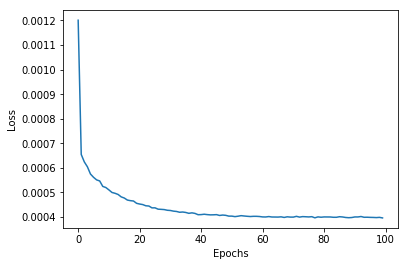

In [17]:
from matplotlib import pyplot as plt
learning =[]
for i in range(arguments.num_epochs):
    a = (len(loss_list)/arguments.num_epochs)*(i)
    b = (len(loss_list)/arguments.num_epochs)*(i+1)
    learning.append(np.mean(loss_list[a:b]))

plt.plot(learning)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [16]:
for i in range(arguments.num_epochs):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [13]:
#Modelo12
path_model = 'FO_UCY-ZARA01_NON_12/model.ckpt-79200'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data_test, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

  7%|6         | 8/118 [00:00<00:01, 72.25it/s]

Evaluating


100%|##########| 118/118 [00:01<00:00, 86.13it/s]

{'ade': 0.40945446, 'fde': 0.9020383}


In [14]:
# Mejor Modelo
path_model = 'FO_UCY-ZARA01_NON-BEST_12/model_best.ckpt-40200'
saver.restore(sess=sess, save_path=path_model)

test_data = batches_data.Dataset(data_test, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

  6%|5         | 7/118 [00:00<00:01, 68.71it/s]

Evaluating


100%|##########| 118/118 [00:01<00:00, 86.38it/s]

{'ade': 0.4067699, 'fde': 0.8927642}
